# Broadcast

## But : Faire un broadcast, départ décalé 


### Informations générales

#### Le nom de l'expérience : Nom du folder contenant les fichiers sources et résultats

In [1]:
experiment_name = "Time_Bcast"
crashed = True

#### Versions

In [2]:
%%bash -s
git log -n 1
python3 --version
R --version

commit 94920e4e09128c1ac89089a59b77fd0eea2e9e97
Author: Najwa Ez Zine <nezzine@fnancy>
Date:   Wed Jul 18 16:15:59 2018 +0200

    Automatic results update : Time_Bcast --- None  GGplot fixing
Python 3.5.3
R version 3.3.3 (2017-03-06) -- "Another Canoe"
Copyright (C) 2017 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
http://www.gnu.org/licenses/.



### Préparation de l'environnement (FRONTEND)

#### Installation des modules

In [3]:
%%bash -s
pip3 install --user execo
pip3 install --user requests

# Permet affichage pllus lisible avec couleurs
pip3 install --user termcolor

# Permettent d'utiliser R :
pip3 install --user rpy2
pip3 install --user tzlocal

  Using cached https://files.pythonhosted.org/packages/65/47/7e02164a2a3db50ed6d8a6ab1d6d60b69c4c3fdf57a284257925dfc12bda/requests-2.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7c/e6/92ad559b7192d846975fc916b65f667c7b8c3a32bea7372340bfe9a15fa5/certifi-2018.4.16-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4b/2a/0276479a4b3caeb8a8c1af2f8e4355746a97fab05a372e4a2c6a6b876165/idna-2.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/c9/6fdd990019071a4a32a5e7cb78a1d92c53851ef4f56f62a3486e6a7d8ffb/urllib3-1.23-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/67/4b/141a581104b1f6397bfa78ac9d43d8ad29a7ca43ea90a2d863fe3056e86a/six-1.11.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/ff/

#### Chargement des modules dans l'environnement

In [4]:
import execo
import math
import collections
import os
import sys
import json
import time
import random
import datetime
import re
import tzlocal

from execo import *
from execo_g5k import *
from execo_engine import *

from shutil import copy
from subprocess import check_output

from threading import Thread

from collections import deque, OrderedDict
from termcolor import *
from subprocess import *

#### Chargement de l'outil permettant l'utilisation de R

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
#install.packages('ggplot2')
#install.packages('dplyr')
#install.packages('tidyr')

NULL


In [7]:
%%R
packageVersion('ggplot2')

[1] ‘2.2.1’


In [8]:
%%R
packageVersion('dplyr')

[1] ‘0.7.6’


In [9]:
%%R
packageVersion('tidyr')

[1] ‘0.8.1’


### Tools

#### Affichage coloré

In [10]:
# Termcolor
# OPTIONS  : bold, dark, underline, blink, reverse, concealed

text = colored('Hello, World!', 'red', attrs = ['blink'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['dark'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['underline'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['bold'])
print(text)

text = colored('Hello, World!', 'red', attrs = ['concealed'])
print(text)

cprint('Hello, World!', 'green', 'on_red',attrs = ['reverse'])

Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!
Hello, World!


#### Affichage lisible d'un dictionnaire complexe

In [11]:
# Display more readable dict
# SOURCE : https://stackoverflow.com/questions/3229419/how-to-pretty-print-nested-dictionaries
def pretty(d, indent = 0):
    for key, value in d.items():
        print('\t' * indent + colored (str(key), "magenta"))
        if isinstance(value, type({})):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

### Préparation de l'environnement pour l'expérience

#### Paramètres réservation

In [12]:
# Nom du job
jobname = ' '
# Nombre de noeuds
nodecount = 2
# Temps réservation
walltime = "2:0:0" 

# filters out Nantes's econome cluster
resources_selection = " -p \"cluster in ('ecotype','parasilo','graphene','griffon','grisou','uvb','paravance','genepi')\"" 

# Nancy
site = "nancy"

#Type de deploiement 
FILE_DEPLOY = True

#### Réservation

In [13]:
jobs = get_current_oar_jobs()
jobid = None
waiting_jobs = []
while jobs:
    j, site = jobs.pop()
    info = get_oar_job_info(j, site)
    if info['name'] == jobname:
        if info['state'] == 'Running':
            jobid = j
            print("A {} job is already running, using it. jobid is {}".format(jobname, jobid))
            break
        else:
            waiting_jobs.append(j)
if not jobid and not waiting_jobs:
    jobspec = OarSubmission(resources="/cluster=1/nodes={}".format(nodecount), walltime = walltime,
                            additional_options = resources_selection, job_type = "deploy", name = jobname)
    jobid, _ = oarsub([(jobspec, site)]).pop()
    print("New job submitted, jobid is {}".format(jobid))
elif not jobid:
    print("One or more {} jobs exist ({}) but are not running.\n"
          " Connect to the frontend to see what is happening, and/or run the cell again.".format(
          jobname, ", ".join([str(j) for j in waiting_jobs])))

A   job is already running, using it. jobid is 1615514


#### Récupération des infos sur les noeuds obtenus

###### Note : Si cette cellule met du temps à répondre, vérifier l'état de la réservation sur la frontale **oartstat -u username** ou via https://www.grid5000.fr/mediawiki/index.php/Status

In [14]:
nodes = get_oar_job_nodes(jobid)
nodes.sort(key = lambda n: n.address)
nodes

[Host('graphene-95.nancy.grid5000.fr'), Host('graphene-97.nancy.grid5000.fr')]

##### Déploiement de l'environnement : 2 options

###### Via fichier 

In [15]:
force_redeploy = False # set to True to force redeploying the OS on the nodes in the deployment section
environment_dsc_file = 'src/debian9-x64-bigdata-tutorial.yaml' # filename of the kadeploy environment file (YAML)

In [16]:
if (FILE_DEPLOY):
    deployment = Deployment(hosts = nodes, env_file = os.path.abspath(environment_dsc_file),
                        other_options = "-r ext4 --no-debug-mode")

    deploy_ok, deploy_failed = deploy(deployment, check_deployed_command = not force_redeploy,
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])
else :
    deploy_ok, deploy_failed = deploy(Deployment(nodes, env_name = "debian9-x64-base",
                              other_options = "-r ext4 --no-debug-mode"),
                              stdout_handlers = [sys.stdout],
                              stderr_handlers = [sys.stderr])

In [17]:
print("Deployement status:\n* ok: {}\n* failed: {}".format(deploy_ok, deploy_failed))

Deployement status:
* ok: {'graphene-95.nancy.grid5000.fr', 'graphene-97.nancy.grid5000.fr'}
* failed: set()


#### Test : commande simple 'ls'

In [18]:
Remote_test = execo.action.Remote(cmd = 'ls',hosts = nodes, connection_params = None, process_args = None)
Remote_test.run().ok

True

#### Installation environnement/tools sur noeuds

In [19]:
if (not crashed):
    Remote_install = execo.action.Remote(cmd = 'apt-get install g++ libboost-all-dev && wget http://gforge.inria.fr/frs/download.php/latestfile/8/SimGrid-3.18.tar.gz && tar -xvf SimGrid-3.18.tar.gz && cd SimGrid-3.18 && cmake -DCMAKE_INSTALL_PREFIX=/usr/local -Denable_smpi=on -Denable_documentation=off && make -j && make check && make install -j',
                                         hosts = nodes,
                                         connection_params = {'user':'root'})
    Remote_install.run().ok

In [20]:
if (not crashed):
    Pajeng_install = execo.action.Remote(cmd = 'git clone git://github.com/schnorr/pajeng.git ; mkdir -p pajeng/build ; cd pajeng/build ; cmake .. ; make ; make install',
                                         hosts = nodes,
                                         connection_params = {'user':'root'}
                                        ).run().ok
    Pajeng_install

#### Version Simgrid

In [21]:
def remote_version(software):
    execo.action.Remote(cmd = 'touch version.txt &&' + str(software) + ' --version > version.txt', 
                        hosts = nodes, 
                        connection_params = {'user': 'root'}
                       ).run()

    version = ''

    for i in range(0, nodecount):
        execo.action.Get(hosts = nodes[i], remote_files = ['~/version.txt'],
                         local_location = './version-'
                                            + get_host_shortname(nodes[i]) + '.txt',
                         connection_params = {'user': 'root'}).run()
    
        version = version + execo.Process(cmd = 'cat ./version-'
                                                + get_host_shortname(nodes[i]) 
                                                + '.txt').run().stdout
        execo.Process(cmd = 'rm ./version-'
                            + get_host_shortname(nodes[i]) + '.txt').run()

    print(colored('VERSION : ' + str(software),"blue"), '\n' + version + '\n')
    return

remote_version('smpicc')
remote_version('g++')
remote_version('pj_dump')

VERSION : smpicc 
SimGrid version 3.18
SimGrid version 3.18


VERSION : g++ 
g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Debian 6.3.0-18) 6.3.0 20170516
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



VERSION : pj_dump 

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)

Development build at commit b9780a1 (2017-08-03 15:05:05 -0300)




#### Chemins (à configurer)

In [22]:
path_base = "/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/" + experiment_name
path_src = path_base + '/src/'
path_rslt = path_base + '/results/'

#### Traitement des données pour les calculs de D et S

In [23]:
# Intialise tableau
def init_tab(num, elt) :
    D = [elt] * num
    return D

# Parsing the results
def parser(num_node, date_precise):
    with open( path_rslt
               + date_precise.split('_')[0] + '/'
               + get_host_shortname(nodes[num_node]) + '_'
               + date_precise
               + '.txt') as f:
        return f.readlines()
    
# Converting and organizing data
def tab_conv(l, NPROCS, precision) :
    S = init_tab(NPROCS, None)
        
    # On récupère les données des fichiers
    # Un fichier contient des lignes telles que : From 0 -> S[0] : 0.0819526    
    for i in range(0, NPROCS) :
        line = l[i].split()
        S[int(line[1])] = round(float(line[5]), precision)
    return S

def delayer(num_node, NPROCS, date, precision):
    D = init_tab(NPROCS, 0.0)
    
    raw_data = parser(num_node, date)
    
    S = tab_conv(raw_data, NPROCS, precision)
    
    for p in range(0, NPROCS):
        D[p] = round(S[p] - min(S), precision)
    return [D, min(S)]

In [24]:
# Example
# delayer(0,10,'2018-06-04_12:38',2)

## SIMULATION

#### Mise en place de l'environnement (fichiers src simulation...) sur noeuds

In [25]:
def env_setup() :
    Src_dir = execo.action.Remote(cmd = 'mkdir -p experiments_src',
                                  hosts = nodes,
                                  connection_params = {'user': 'root'})
    Src_get = execo.action.Put(hosts = nodes,
                               local_files = [path_src
                                   + 'griffon.xml', path_src
                                   + 'griffon_hostfile.txt', path_src
                                   + 'broadcast.c', path_src 
                                   + 'Makefile'],
                                remote_location = '~/experiments_src',
                                connection_params = {'user': 'root'})
    Rslt_dir = execo.Process(cmd = 'mkdir -p '
                                  + path_rslt
                                  + datetime.datetime.now().strftime('%Y-%m-%d'))

# On récup les src
    if not (Src_dir.run().ok 
            and Src_get.run().ok 
            and Rslt_dir.run().ok):
        raise Error("Environnement could not be set : Check files")


#### Défintion du thread pour parallélisation de la simulation

In [26]:
# Thread pour la simulation // opt.
class ParSimer(Thread):

    """Thread chargé simplement d'afficher une lettre dans la console."""
    
    # Paramètrage du thread
    def __init__(self, i, MIN, MAX, N, DELAY):
        Thread.__init__(self)
        self.MIN = MIN
        self.MAX = MAX
        self.N = N
        self.DELAY = DELAY
        self.i = i
    
    # Set la valeur du délai
    def set_delay(self, delay):
        self.DELAY = delay
    
    def get_delay(self):
        return self.DELAY
    
    def get_MIN(self):
        return self.MIN
    
    def run(self):
        """Code à exécuter pendant l'exécution du thread."""
        if (DEBUG): 
            print(
                get_host_shortname(nodes[self.i]) + " => NPROCS = " + str(NPROCS)
             + " MIN = " + str(self.MIN)
             + " MAX = " + str(self.MAX)
             + " N = " + str(self.N)
             + " DELAY = '" + self.DELAY + "'\n"
            )
       
        # make run sur toutes la machine dont le thread s'occupe avec ses paramètres
        execo.action.Remote(cmd ='cd ~/experiments_src && make && make run NPROCS='
                                  + str(NPROCS) + ' MIN='+ str(self.MIN) 
                                  + ' MAX=' + str(self.MAX) + ' N=' + str(self.N)
                                  + " DELAY='" + self.DELAY
                                  + "'" , 
                            hosts = nodes[self.i], 
                            connection_params = {'user':'root'}).run().ok


#### Conversion string < = > int pour manipulation de D & S

In [27]:
# Formate le tableau en string pour pouvoir etre passé en ligne de commande
def format_cmd(data):
    return (' '.join(str(e) for e in data))

# Formate le string en tableau d'int pour être manipulé 
def unformat_cmd(data):
    return list(map(float, data.split()))

#### Génération du nouvel état initial

In [28]:
smart_table = {}

def reset_smart_table():
    smart_table = OrderedDict()
    return

def update_smart_table(final_state, t):
    final_state = unformat_cmd(final_state)
    smart_table.setdefault(t, [final_state,2])
    nb_val = smart_table[t][1]
    
    
    for i in range(NPROCS):
        smart_table[t][0][i] = (smart_table[t][0][i] * (nb_val - 1) + final_state[i]) / nb_val    
        
    smart_table[t][1] +=1

def generate_Dprime(NPROCS, border_inf, border_sup, precision):
    # Variable pour le stockage du nouveau D
    new_Dprime = []

    for p in range(NPROCS):
        random_value = random.uniform(border_inf[p], border_sup[p])
        round_value = round(random_value, precision)
        new_Dprime.append(round_value)
    return format_cmd(new_Dprime)

def generate_initial_state(mode, final_state, t):
    borders = unformat_cmd(final_state)
    # S'il n'y a pas de limite supérieure, on limite au double de l'état final obtenu
    double_Dprime = [(2 * (x)) for x in borders]
                      
    # Bornes pour le random 
    border_inf = init_tab(NPROCS, 0.0)
    border_sup = double_Dprime
    if (mode == "RAND_SUP") : 
        border_sup = borders
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND_INF") : 
        border_inf = borders
        new_initial_state = generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "RAND") : 
        new_initial_state =  generate_Dprime(NPROCS, border_inf, border_sup, precision)
    elif (mode == "SMART_GUESS"):
        update_smart_table(final_state, t)
        new_initial_state = format_cmd(smart_table[t][0])
    return new_initial_state

#### Fonctions pour la simulation

In [29]:
def date_setup():
    date_precise = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M')
    date = date_precise.split('_')[0]
    return date_precise, date

def get_results(date_precise, q):
    date = date_precise.split('_')[0]
    execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/bcast_results.txt'],
            local_location = path_rslt
                            + date + '/' 
                            + get_host_shortname(nodes[q]) + '_'
                            + date_precise + '.txt', 
            connection_params = {'user': 'root'}
                       ).run().ok


def pj_dump(date, filename, q):
        execo.action.Remote(
            cmd = 'pj_dump --ignore-incomplete-links ./experiments_src/Time_Bcast.trace > ./experiments_src/Time_Bcast.csv && cp  ./experiments_src/Time_Bcast.csv  ./experiments_src/'+str(q)+'.csv',
            hosts = nodes[q],
            connection_params = {'user':'root'}
        ).run()

        execo.action.Remote(
            cmd = 'grep State '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.state.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        execo.action.Remote(
            cmd = 'grep Link '+ str(filename) + '.csv > ~/experiments_src/Time_Bcast.link.csv',
            hosts = nodes[q],
            connection_params = {'user': 'root'}
        ).run()
        return
        
def get_csv(date, q):
        execo.action.Get(
            hosts = nodes[q],
            remote_files = ['~/experiments_src/*.csv'],
            local_location = path_base, 
            connection_params = {'user': 'root'}
        ).run()

def draw_ggplot(MIN, MAX, D):
            %R library(ggplot2)
            %R -i MIN 
            %R -i MAX 
            %R -i D
            %R df_state = read.csv("/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/Time_Bcast.state.csv", header = F, strip.white=T)
            %R names(df_state) = c("Type", "Rank", "Container", "Start", "End", "Duration", "Level", "State"); 
            %R df_state = df_state[!(names(df_state) %in% c("Type","Container","Level"))]
            %R df_state$Rank = as.numeric(gsub("rank-","",df_state$Rank))
            %R gc = ggplot(data=df_state) + geom_rect(aes(xmin=Start, xmax=End, ymin=Rank, ymax=Rank+1,fill=State)) + scale_fill_brewer(palette="Set1")
            %R df_link = read.csv("/home/nezzine/Stage-POLARIS/SimGrid/examples/SMPI/Time_Bcast/Time_Bcast.link.csv", header=F, strip.white=T)
            %R names(df_link) = c("Type", "Level", "Container", "Start", "End", "Duration", "CommType", "Src", "Dst"); 
            %R df_link = df_link[!(names(df_link) %in% c("Type","Container","Level","CommType"))]
            %R df_link$Src = as.numeric(gsub("rank-","",df_link$Src))
            %R df_link$Dst = as.numeric(gsub("rank-","",df_link$Dst))
#             %R head(df_link)
            %R str(df_link)
#             %R step = round((max(df_link$End)/7),5)
            %R step = 0.0025
            %R print(df_state)
            %R print(df_link)
            %R print(gc + geom_segment(data = df_link, aes(x = Start, y = Src, xend = End, yend = Dst),arrow = arrow(length = unit(0.01, "npc"))) + scale_x_continuous(breaks = seq(0, 0.02, by = step)) + ggtitle(paste('Zone : ' , MIN, ' - ', MAX, '\nPour D', D) ))

--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

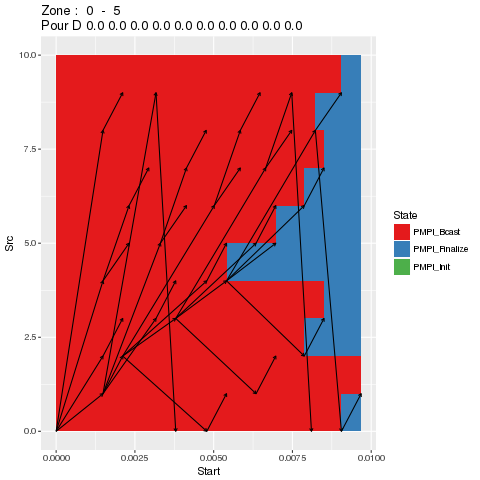

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

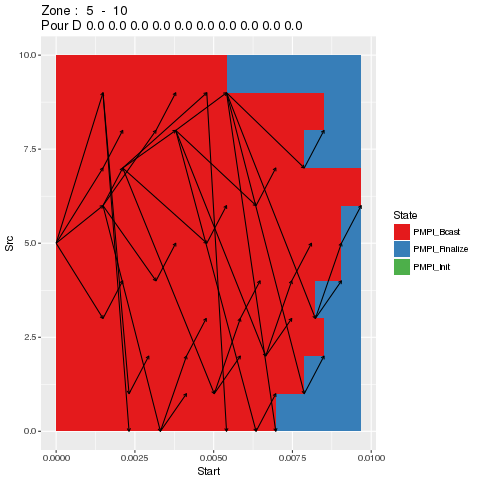

T_curr :  0
total execution time :  0

merging : 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

  || RESULTS || 

T_curr :  5
total execution time :  0.0054

  || ANALYSIS || 

--------------------------------------------  ROUND :  2   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

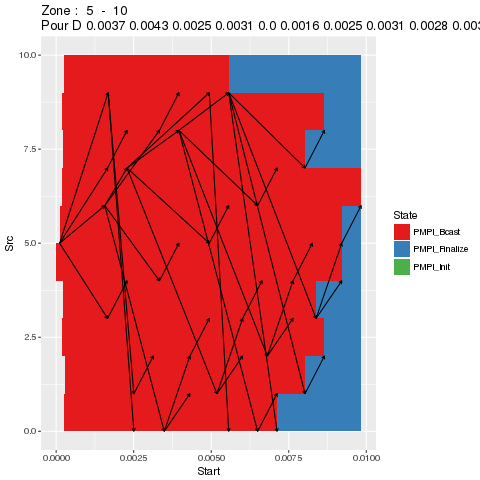

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

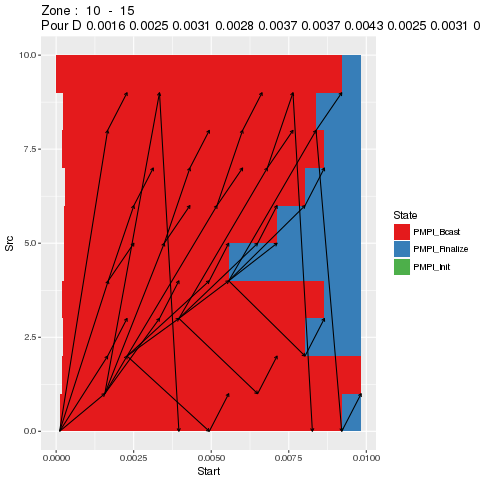

T_curr :  5
total execution time :  0.0054

merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  15
total execution time :  0.0166

  || ANALYSIS || 

--------------------------------------------  ROUND :  3   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

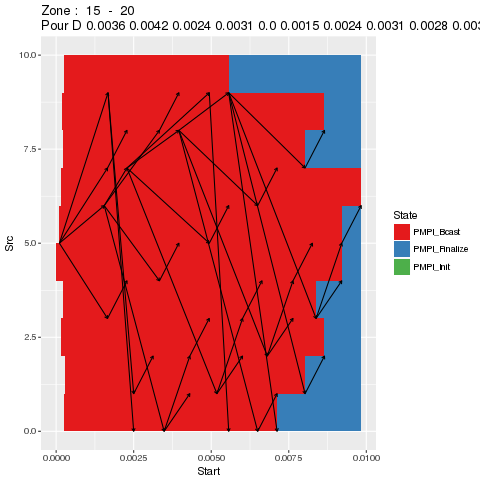

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

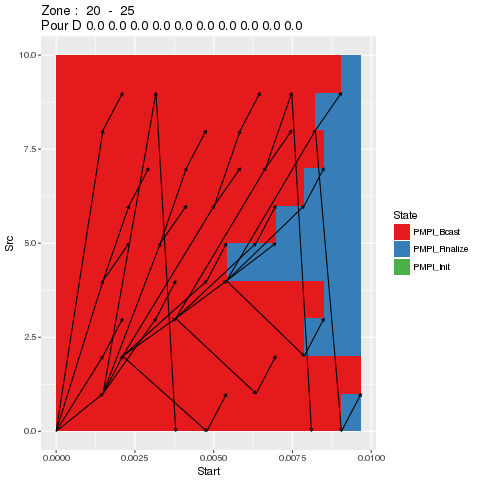

T_curr :  15
total execution time :  0.0166

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  20
total execution time :  0.0222

  || ANALYSIS || 

--------------------------------------------  ROUND :  4   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

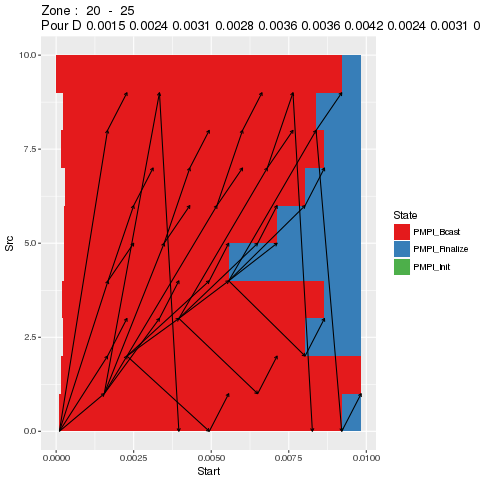

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

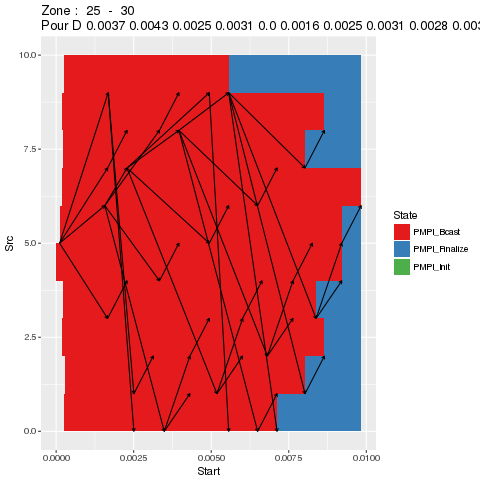

T_curr :  20
total execution time :  0.0222

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  30
total execution time :  0.0334

  || ANALYSIS || 

--------------------------------------------  ROUND :  5   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

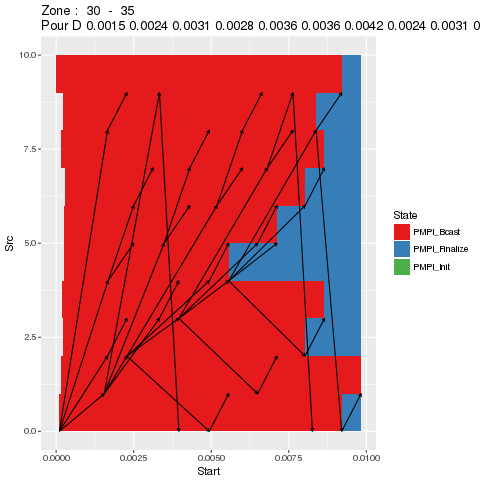

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

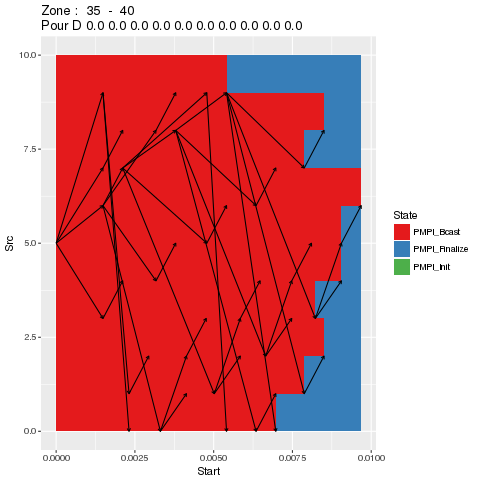

T_curr :  30
total execution time :  0.0334

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  35
total execution time :  0.039

  || ANALYSIS || 

--------------------------------------------  ROUND :  6   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

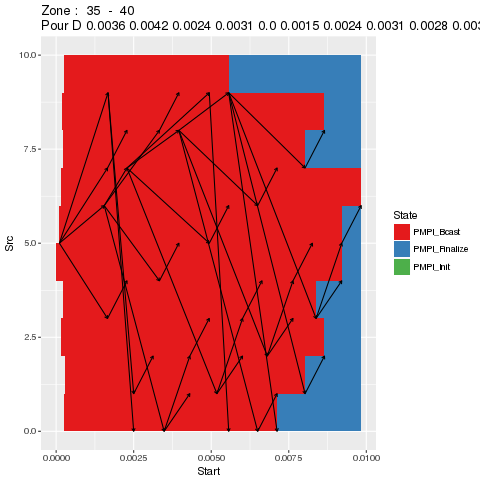

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

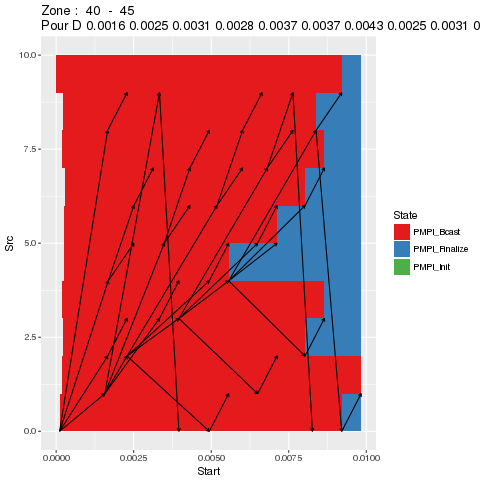

T_curr :  35
total execution time :  0.039

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  45
total execution time :  0.0502

  || ANALYSIS || 

--------------------------------------------  ROUND :  7   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

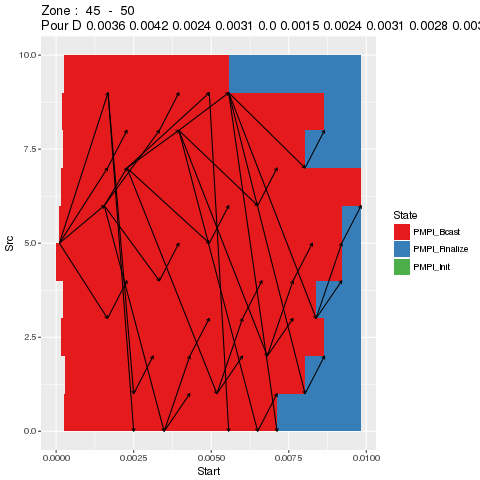

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

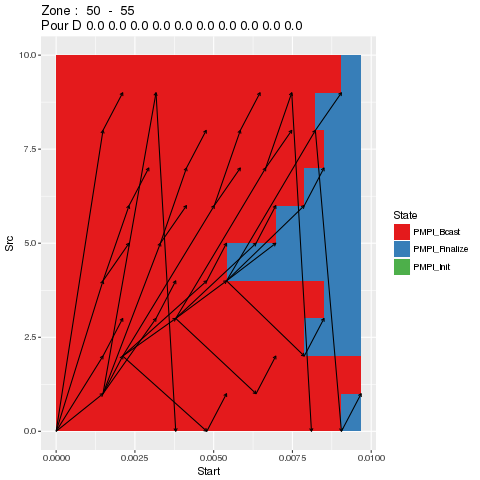

T_curr :  45
total execution time :  0.0502

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  50
total execution time :  0.0558

  || ANALYSIS || 

--------------------------------------------  ROUND :  8   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

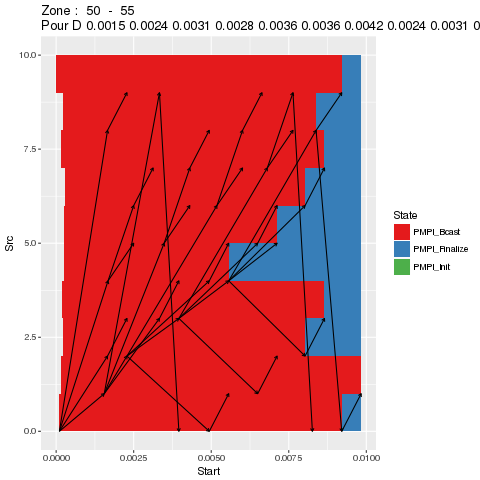

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

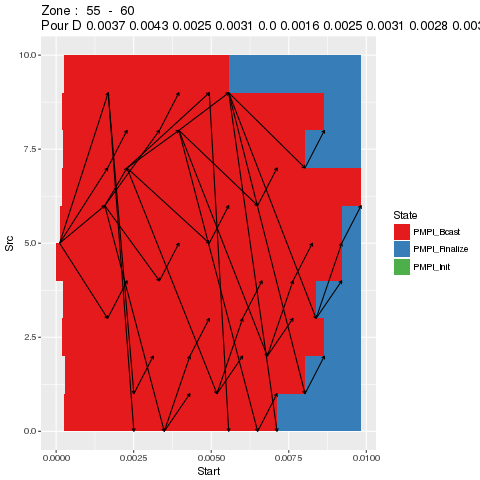

T_curr :  50
total execution time :  0.0558

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  60
total execution time :  0.067

  || ANALYSIS || 

--------------------------------------------  ROUND :  9   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

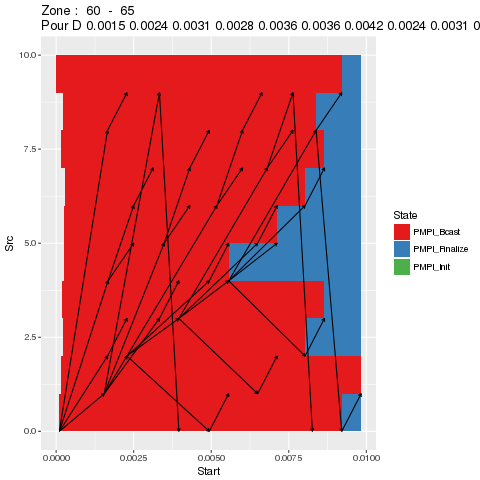

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

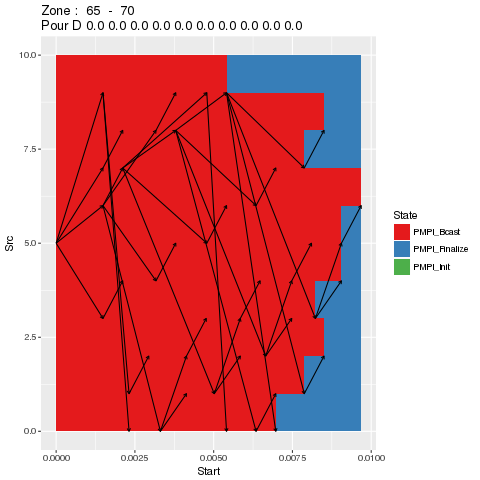

T_curr :  60
total execution time :  0.067

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  65
total execution time :  0.0726

  || ANALYSIS || 

--------------------------------------------  ROUND :  10   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

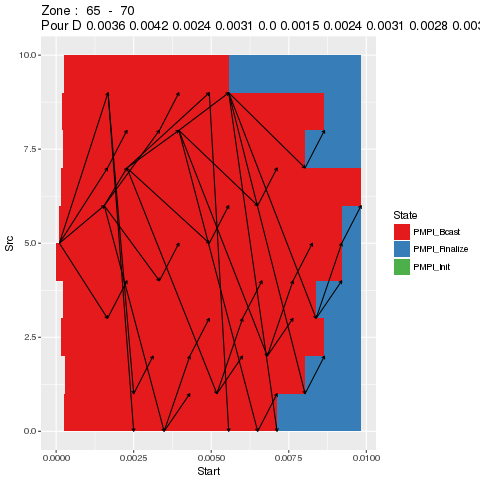

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001660 0.001443    PMPI_Bcast
3     8 0.001660 0.004939 0.003279    PMPI_Bcast
4     8 0.004939 0.006012 0.001073    PMPI_Bcast
5     8 0.006012 0.007636 0.001624    PMPI_Bcast
6     8 0.007636 0.008380 0.000744    PMPI_Bcast
7     8 0.008380 0.009834 0.001454 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000175 0.003132 0.002957    PMPI_Bcast
10    7 0.003132 0.004313 0.001181    PMPI_Bcast
11    7 0.004313 0.006012 0.001699    PMPI_Bcast
12    7 0.006012 0.006809 0.000797    PMPI_Bcast
13    7 0.006809 0.008650 0.001841    PMPI_Bcast
14    7 0.008650 0.009834 0.001184 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000301 0.002506 0.002205    PMPI_Bcast
17    6 0.002506 0.004313 0.001807    PMPI_Bcast
18    6 0.004313 0.005185 0.000872    PMPI_Bcast
19    6 0.005185 0.007123 0.001938    PMPI_Bcast
20    6 0.007123 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   0   1  0_1_-3334_4
2  0.000112 0.001660 0.001548   0   8  0_8_-3334_1
3  0.000112 0.001660 0.001548   0   2  0_2_-3334_3
4  0.000112 0.001679 0.001567   0   4  0_4_-3334_2
5  0.001569 0.002286 0.000717   1   2  1_2_-3334_8
6  0.001660 0.002286 0.000626   2   3 2_3_-3334_10
7  0.001660 0.002286 0.000626   8   9  8_9_-3334_9
8  0.001679 0.002506 0.000827   4   5 4_5_-3334_12
9  0.001679 0.002506 0.000827   4   6 4_6_-3334_11
10 0.002506 0.003132 0.000626   6   7 6_7_-3334_17
11 0.001569 0.003332 0.001763   1   9  1_9_-3334_5
12 0.001569 0.003332 0.001763   1   3  1_3_-3334_7
13 0.001569 0.003486 0.001917   1   5  1_5_-3334_6
14 0.002286 0.003958 0.001672   2   3 2_3_-3334_16
15 0.003332 0.003958 0.000626   3   4 3_4_-3334_19
16 0.003332 0.003958 0.000626   9   0 9_0_-3334_18
17 0.003486 0.004313 0.000827   5   6 5_6_-3334_21
18 0.003486 0.004313 0.000827   5   7 5_7_-3334_20
19 0.002286 0.004938 0.002652  

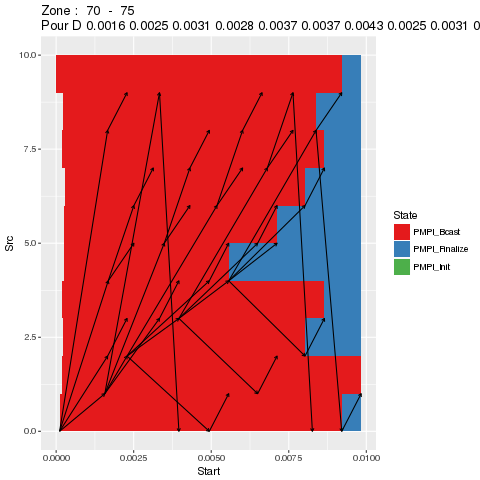

T_curr :  65
total execution time :  0.0726

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036
merging : 0.0016 0.0025 0.0031 0.0028 0.0037 0.0037 0.0043 0.0025 0.0031 0.0
****** SUCCESS : 2

  || RESULTS || 

T_curr :  75
total execution time :  0.08379999999999999

  || ANALYSIS || 

--------------------------------------------  ROUND :  11   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

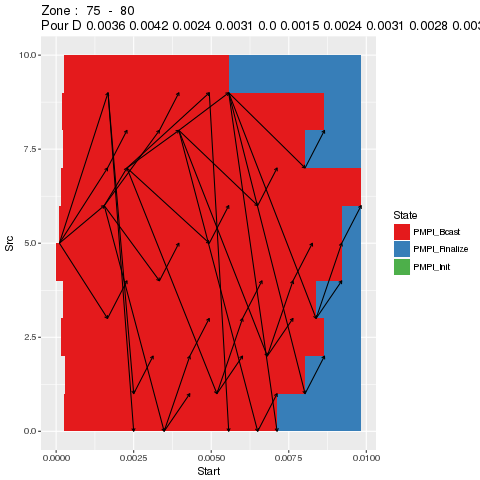

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 2 4 8 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 4 5 6 7 15 43 24 28 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.001487 0.001487    PMPI_Bcast
3     8 0.001487 0.004763 0.003276    PMPI_Bcast
4     8 0.004763 0.005846 0.001083    PMPI_Bcast
5     8 0.005846 0.007478 0.001632    PMPI_Bcast
6     8 0.007478 0.008228 0.000750    PMPI_Bcast
7     8 0.008228 0.009681 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.002940 0.002940    PMPI_Bcast
10    7 0.002940 0.004137 0.001197    PMPI_Bcast
11    7 0.004137 0.005846 0.001709    PMPI_Bcast
12    7 0.005846 0.006651 0.000805    PMPI_Bcast
13    7 0.006651 0.008502 0.001851    PMPI_Bcast
14    7 0.008502 0.009681 0.001179 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.002314 0.002314    PMPI_Bcast
17    6 0.002314 0.004137 0.001823    PMPI_Bcast
18    6 0.004137 0.005019 0.000882    PMPI_Bcast
19    6 0.005019 0.006972 0.001953    PMPI_Bcast
20    6 0.006972 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   0   1  0_1_-3334_4
2  0.000000 0.001487 0.001487   0   2  0_2_-3334_3
3  0.000000 0.001487 0.001487   0   4  0_4_-3334_2
4  0.000000 0.001487 0.001487   0   8  0_8_-3334_1
5  0.001487 0.002113 0.000626   1   2 1_2_-3334_12
6  0.001487 0.002113 0.000626   2   3  2_3_-3334_6
7  0.001487 0.002113 0.000626   8   9  8_9_-3334_8
8  0.001487 0.002314 0.000827   4   5 4_5_-3334_10
9  0.001487 0.002314 0.000827   4   6  4_6_-3334_7
10 0.002314 0.002940 0.000626   6   7 6_7_-3334_17
11 0.001487 0.003170 0.001683   1   9  1_9_-3334_5
12 0.001487 0.003170 0.001683   1   3 1_3_-3334_11
13 0.001487 0.003309 0.001822   1   5  1_5_-3334_9
14 0.002113 0.003796 0.001683   2   3 2_3_-3334_16
15 0.003170 0.003796 0.000626   3   4 3_4_-3334_19
16 0.003170 0.003796 0.000626   9   0 9_0_-3334_18
17 0.003309 0.004137 0.000828   5   6 5_6_-3334_21
18 0.003309 0.004137 0.000828   5   7 5_7_-3334_20
19 0.004137 0.004763 0.000626  

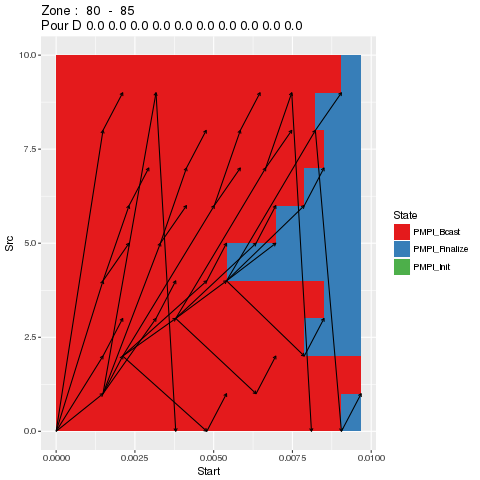

T_curr :  75
total execution time :  0.08379999999999999

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  80
total execution time :  0.08939999999999998

  || ANALYSIS || 

--------------------------------------------  ROUND :  12   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

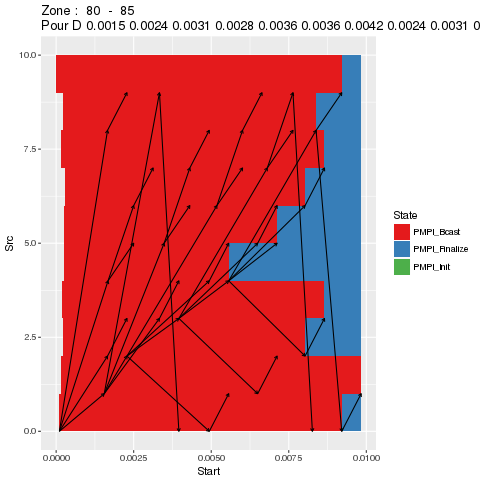

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000112 0.000112 0.000112 0.000112 0.001569 ...
 $ End     : num  0.00157 0.00166 0.00166 0.00168 0.00229 ...
 $ Duration: num  0.001457 0.001548 0.001548 0.001567 0.000717 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002286 0.002090    PMPI_Bcast
3     8 0.002286 0.003332 0.001046    PMPI_Bcast
4     8 0.003332 0.003958 0.000626    PMPI_Bcast
5     8 0.003958 0.003958 0.000000    PMPI_Bcast
6     8 0.003958 0.008650 0.004692    PMPI_Bcast
7     8 0.008650 0.009834 0.001184 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001660 0.001443    PMPI_Bcast
10    7 0.001660 0.002286 0.000626    PMPI_Bcast
11    7 0.002286 0.002286 0.000000    PMPI_Bcast
12    7 0.002286 0.007123 0.004837    PMPI_Bcast
13    7 0.007123 0.008024 0.000901    PMPI_Bcast
14    7 0.008024 0.009834 0.001810 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000175 0.001569 0.001394    PMPI_Bcast
17    6 0.001569 0.001569 0.000000    PMPI_Bcast
18    6 0.001569 0.005564 0.003995    PMPI_Bcast
19    6 0.005564 0.006497 0.000933    PMPI_Bcast
20    6 0.006497 0.0

      Start      End Duration Src Dst           NA
1  0.000112 0.001569 0.001457   5   6  5_6_-3334_4
2  0.000112 0.001660 0.001548   5   7  5_7_-3334_3
3  0.000112 0.001660 0.001548   5   3  5_3_-3334_1
4  0.000112 0.001679 0.001567   5   9  5_9_-3334_2
5  0.001569 0.002286 0.000717   6   7  6_7_-3334_8
6  0.001660 0.002286 0.000626   3   4 3_4_-3334_10
7  0.001660 0.002286 0.000626   7   8  7_8_-3334_9
8  0.001679 0.002506 0.000827   9   0 9_0_-3334_12
9  0.001679 0.002506 0.000827   9   1 9_1_-3334_11
10 0.002506 0.003132 0.000626   1   2 1_2_-3334_17
11 0.001569 0.003332 0.001763   6   8  6_8_-3334_7
12 0.001569 0.003332 0.001763   6   4  6_4_-3334_5
13 0.001569 0.003486 0.001917   6   0  6_0_-3334_6
14 0.002286 0.003958 0.001672   7   8 7_8_-3334_16
15 0.003332 0.003958 0.000626   4   5 4_5_-3334_19
16 0.003332 0.003958 0.000626   8   9 8_9_-3334_18
17 0.003486 0.004313 0.000827   0   1 0_1_-3334_21
18 0.003486 0.004313 0.000827   0   2 0_2_-3334_20
19 0.002286 0.004938 0.002652  

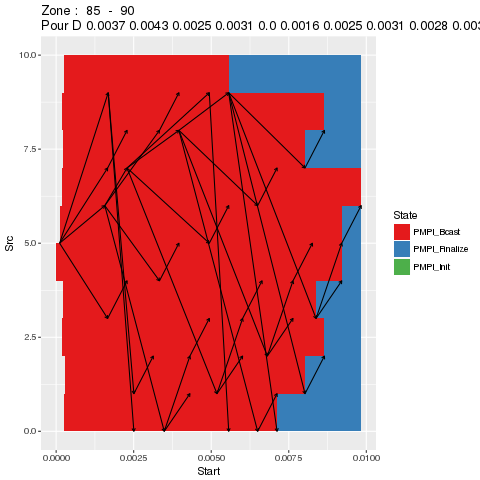

T_curr :  80
total execution time :  0.08939999999999998

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0
merging : 0.0037 0.0043 0.0025 0.0031 0.0 0.0016 0.0025 0.0031 0.0028 0.0037
****** SUCCESS : 2

  || RESULTS || 

T_curr :  90
total execution time :  0.10059999999999997

  || ANALYSIS || 

--------------------------------------------  ROUND :  13   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  0 0 0 0 1 2 8 4 4 6 ...
 $ Dst     : num  1 8 2 4 2 3 9 5 6 7 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_27",..: 2 6 4 5 8 13 43 24 27 33 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000217 0.001657 0.001440    PMPI_Bcast
3     8 0.001657 0.004936 0.003279    PMPI_Bcast
4     8 0.004936 0.006010 0.001074    PMPI_Bcast
5     8 0.006010 0.007636 0.001626    PMPI_Bcast
6     8 0.007636 0.008381 0.000745    PMPI_Bcast
7     8 0.008381 0.009834 0.001453 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000168 0.003126 0.002958    PMPI_Bcast
10    7 0.003126 0.004310 0.001184    PMPI_Bcast
11    7 0.004310 0.006010 0.001700    PMPI_Bcast
12    7 0.006010 0.006808 0.000798    PMPI_Bcast
13    7 0.006808 0.008652 0.001844    PMPI_Bcast
14    7 0.008652 0.009834 0.001182 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000294 0.002500 0.002206    PMPI_Bcast
17    6 0.002500 0.004310 0.001810    PMPI_Bcast
18    6 0.004310 0.005183 0.000873    PMPI_Bcast
19    6 0.005183 0.007124 0.001941    PMPI_Bcast
20    6 0.007124 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   0   1  0_1_-3334_4
2  0.000105 0.001657 0.001552   0   8  0_8_-3334_1
3  0.000105 0.001657 0.001552   0   2  0_2_-3334_3
4  0.000105 0.001673 0.001568   0   4  0_4_-3334_2
5  0.001551 0.002283 0.000732   1   2  1_2_-3334_8
6  0.001657 0.002283 0.000626   2   3 2_3_-3334_10
7  0.001657 0.002283 0.000626   8   9  8_9_-3334_9
8  0.001673 0.002500 0.000827   4   5 4_5_-3334_12
9  0.001673 0.002500 0.000827   4   6 4_6_-3334_11
10 0.002500 0.003126 0.000626   6   7 6_7_-3334_17
11 0.001551 0.003331 0.001780   1   9  1_9_-3334_5
12 0.001551 0.003331 0.001780   1   3  1_3_-3334_7
13 0.001551 0.003482 0.001931   1   5  1_5_-3334_6
14 0.002283 0.003957 0.001674   2   3 2_3_-3334_16
15 0.003331 0.003957 0.000626   3   4 3_4_-3334_19
16 0.003331 0.003957 0.000626   9   0 9_0_-3334_18
17 0.003482 0.004310 0.000828   5   6 5_6_-3334_21
18 0.003482 0.004310 0.000828   5   7 5_7_-3334_20
19 0.004310 0.004936 0.000626  

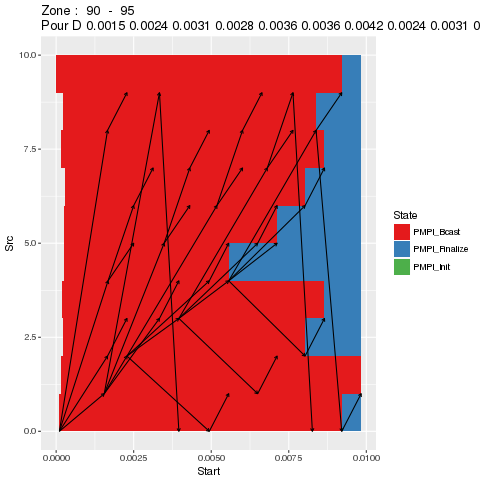

'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0 0 0 0 0.00149 ...
 $ End     : num  0.00149 0.00149 0.00149 0.00149 0.00211 ...
 $ Duration: num  0.001487 0.001487 0.001487 0.001487 0.000626 ...
 $ Src     : num  5 5 5 5 6 7 3 9 9 1 ...
 $ Dst     : num  6 7 9 3 7 8 4 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 22 17 25 32 13 39 43 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000000 0.002113 0.002113    PMPI_Bcast
3     8 0.002113 0.003170 0.001057    PMPI_Bcast
4     8 0.003170 0.003796 0.000626    PMPI_Bcast
5     8 0.003796 0.003796 0.000000    PMPI_Bcast
6     8 0.003796 0.008502 0.004706    PMPI_Bcast
7     8 0.008502 0.009681 0.001179 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000000 0.001487 0.001487    PMPI_Bcast
10    7 0.001487 0.002113 0.000626    PMPI_Bcast
11    7 0.002113 0.002113 0.000000    PMPI_Bcast
12    7 0.002113 0.006972 0.004859    PMPI_Bcast
13    7 0.006972 0.007876 0.000904    PMPI_Bcast
14    7 0.007876 0.009681 0.001805 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000000 0.001487 0.001487    PMPI_Bcast
17    6 0.001487 0.001487 0.000000    PMPI_Bcast
18    6 0.001487 0.005408 0.003921    PMPI_Bcast
19    6 0.005408 0.006346 0.000938    PMPI_Bcast
20    6 0.006346 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001487 0.001487   5   6  5_6_-3334_4
2  0.000000 0.001487 0.001487   5   7  5_7_-3334_3
3  0.000000 0.001487 0.001487   5   9  5_9_-3334_2
4  0.000000 0.001487 0.001487   5   3  5_3_-3334_1
5  0.001487 0.002113 0.000626   6   7 6_7_-3334_12
6  0.001487 0.002113 0.000626   7   8  7_8_-3334_6
7  0.001487 0.002113 0.000626   3   4  3_4_-3334_8
8  0.001487 0.002314 0.000827   9   0 9_0_-3334_10
9  0.001487 0.002314 0.000827   9   1  9_1_-3334_7
10 0.002314 0.002940 0.000626   1   2 1_2_-3334_17
11 0.001487 0.003170 0.001683   6   4  6_4_-3334_5
12 0.001487 0.003170 0.001683   6   8 6_8_-3334_11
13 0.001487 0.003309 0.001822   6   0  6_0_-3334_9
14 0.002113 0.003796 0.001683   7   8 7_8_-3334_16
15 0.003170 0.003796 0.000626   8   9 8_9_-3334_19
16 0.003170 0.003796 0.000626   4   5 4_5_-3334_18
17 0.003309 0.004137 0.000828   0   1 0_1_-3334_21
18 0.003309 0.004137 0.000828   0   2 0_2_-3334_20
19 0.004137 0.004763 0.000626  

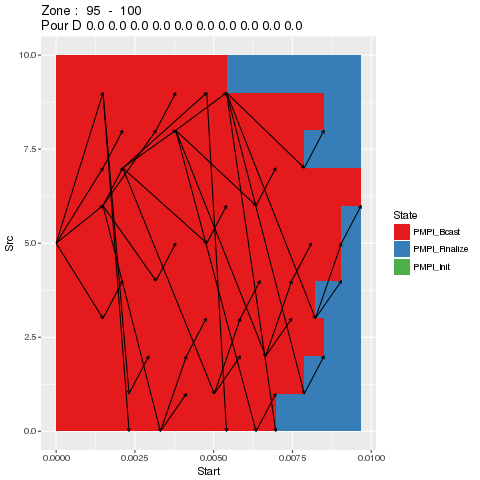

T_curr :  90
total execution time :  0.10059999999999997

merging : 0.0015 0.0024 0.0031 0.0028 0.0036 0.0036 0.0042 0.0024 0.0031 0.0

  || RESULTS || 

T_curr :  95
total execution time :  0.10619999999999996

  || ANALYSIS || 

--------------------------------------------  ROUND :  14   --------------------------------------------

  || LAUNCHING || 



'data.frame':	45 obs. of  6 variables:
 $ Start   : num  0.000105 0.000105 0.000105 0.000105 0.001551 ...
 $ End     : num  0.00155 0.00166 0.00166 0.00167 0.00228 ...
 $ Duration: num  0.001446 0.001552 0.001552 0.001568 0.000732 ...
 $ Src     : num  5 5 5 5 6 3 7 9 9 1 ...
 $ Dst     : num  6 7 3 9 7 4 8 0 1 2 ...
 $ NA      : Factor w/ 45 levels "0_1_-3334_21",..: 19 21 17 22 26 11 32 39 42 4 ...


   Rank    Start      End Duration         State
1     8 0.000000 0.000000 0.000000     PMPI_Init
2     8 0.000196 0.002283 0.002087    PMPI_Bcast
3     8 0.002283 0.003331 0.001048    PMPI_Bcast
4     8 0.003331 0.003957 0.000626    PMPI_Bcast
5     8 0.003957 0.003957 0.000000    PMPI_Bcast
6     8 0.003957 0.008652 0.004695    PMPI_Bcast
7     8 0.008652 0.009834 0.001182 PMPI_Finalize
8     7 0.000000 0.000000 0.000000     PMPI_Init
9     7 0.000217 0.001657 0.001440    PMPI_Bcast
10    7 0.001657 0.002283 0.000626    PMPI_Bcast
11    7 0.002283 0.002283 0.000000    PMPI_Bcast
12    7 0.002283 0.007124 0.004841    PMPI_Bcast
13    7 0.007124 0.008026 0.000902    PMPI_Bcast
14    7 0.008026 0.009834 0.001808 PMPI_Finalize
15    6 0.000000 0.000000 0.000000     PMPI_Init
16    6 0.000168 0.001551 0.001383    PMPI_Bcast
17    6 0.001551 0.001551 0.000000    PMPI_Bcast
18    6 0.001551 0.005564 0.004013    PMPI_Bcast
19    6 0.005564 0.006498 0.000934    PMPI_Bcast
20    6 0.006498 0.0

      Start      End Duration Src Dst           NA
1  0.000105 0.001551 0.001446   5   6  5_6_-3334_4
2  0.000105 0.001657 0.001552   5   7  5_7_-3334_3
3  0.000105 0.001657 0.001552   5   3  5_3_-3334_1
4  0.000105 0.001673 0.001568   5   9  5_9_-3334_2
5  0.001551 0.002283 0.000732   6   7  6_7_-3334_8
6  0.001657 0.002283 0.000626   3   4 3_4_-3334_10
7  0.001657 0.002283 0.000626   7   8  7_8_-3334_9
8  0.001673 0.002500 0.000827   9   0 9_0_-3334_12
9  0.001673 0.002500 0.000827   9   1 9_1_-3334_11
10 0.002500 0.003126 0.000626   1   2 1_2_-3334_17
11 0.001551 0.003331 0.001780   6   8  6_8_-3334_7
12 0.001551 0.003331 0.001780   6   4  6_4_-3334_5
13 0.001551 0.003482 0.001931   6   0  6_0_-3334_6
14 0.002283 0.003957 0.001674   7   8 7_8_-3334_16
15 0.003331 0.003957 0.000626   4   5 4_5_-3334_19
16 0.003331 0.003957 0.000626   8   9 8_9_-3334_18
17 0.003482 0.004310 0.000828   0   1 0_1_-3334_21
18 0.003482 0.004310 0.000828   0   2 0_2_-3334_20
19 0.004310 0.004936 0.000626  

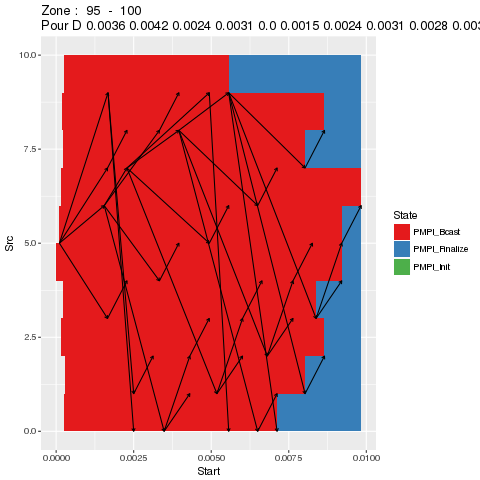

T_curr :  95
total execution time :  0.10619999999999996

merging : 0.0036 0.0042 0.0024 0.0031 0.0 0.0015 0.0024 0.0031 0.0028 0.0036

  || RESULTS || 

T_curr :  100
total execution time :  0.11599999999999995

  || ANALYSIS || 

Total time : 0.11599999999999995
Success : True


In [39]:
NPROCS = 10
DEBUG = False
simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

In [30]:
def state_match(sim, t_curr, D_curr, gap, NPROCS):
#     print("Checking if state match : " + str(D_curr))
    merging = True
    number_of_keys = len(sim[t_curr])
        
    for index in range(number_of_keys):
        D = list(sim[t_curr].keys())[index]
        D = unformat_cmd(D)
        if type(D_curr) is str : D_curr = unformat_cmd(D_curr)
        merging = all(math.isclose(D_curr[i],D[i], abs_tol = gap) for i in range(NPROCS))
        if (merging) : D = format_cmd(D) ; print("merging : " + str(D)); return merging , D
    D_curr = format_cmd(D_curr)
    #print("returning: " + str(D_curr))
    return  merging , D_curr

#### Code de la simulation

In [31]:
# SIMULATION
import warnings
warnings.filterwarnings("ignore")
def simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me):
    
    """Contrôle de la validité des paramètres"""
    # Taille du fragment ne peut être supérieure à la zone d'itération
    if (fragment_size > N): 
        raise ValueError("Fragment size cannot be superior to N")
        
    """Mise en place de l'environnement et des variables"""
    # Environnement
    env_setup() 
    
    # Dates: pour la gestion de fichiers (IMPORTANT pour lecture/écriture)
    date_precise, date = date_setup()   
    
    # Temps d'exécution total
    total_execution_time = 0
    
    # Tableau de threads
    machines = init_tab(nodecount, None)
      
    # position trajectoire cohérente courante
    t_curr = 0
    
    # D de la trajectorie cohérente courante
    D_curr = format_cmd( init_tab( NPROCS, 0.0))

    fragment_number = int((math.ceil(N / fragment_size)))
    
    # zone d'itérations à explorer
    To_explore = collections.deque()
    
    # Initialisation des zones à explorer D = '0...0' pour chaque zone T -> (Min d'itération , D initial)
    for i in range(fragment_number):
        To_explore.append((i * fragment_size, format_cmd(init_tab(NPROCS, 0.0))))

    # Round actuel
    curr_round = 0
    
    # Liste des trajectoires pour un temps t et un D donnée
    sim = OrderedDict()
    
    # Vrai si un état final a fusionné avec un état initial au moins une fois
    success = False 
    
    if (mode == "SMART_GUESS"): reset_smart_table()
    
    catch_me_ind = 0
    
    while(True):
        curr_round = curr_round + 1
        
        # Zones restantes à explorer
        number_paths_To_explore = len(To_explore)
        # Trajectoire cohérente complète trouvé : FIN DE SIMULATION
        if (t_curr >= N) :
            cprint ("Total time : " + str(total_execution_time) , "grey" , "on_yellow")
            cprint ("Success : " + str(success) , "grey" , "on_green")
            break;        
        if (number_paths_To_explore  == 0):
            raise "No path to explore left !"
        # Il n'existe pas encore de trajectoire cohérente -> Nouveau round
        cprint("--------------------------------------------  ROUND :  " + str(curr_round) + "   --------------------------------------------\n","red", attrs=['reverse', 'blink'])
        

        
        # Nombre de tâches parallèles lançables
        number_launchable_tasks = min(nodecount, number_paths_To_explore)
        
        # Affichage des paramètres
        cprint ("  || LAUNCHING || \n","green", attrs=[ 'reverse', 'blink'])
        if (DEBUG): 
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        
        """ Paramètrage des machines """
        
        # Soit j'ai plus de zone à explorer que de machines disponibles soit l'inverse
        for q in range(number_launchable_tasks):
            
            # On récupère la première zone à explorer
            parameters = To_explore.popleft()
            
            # MIN est le champ de gauche
            MIN = parameters[0]
            
            # MAX de la zone à explorer vaut le min + la taille du slot
            MAX = min (MIN + fragment_size, N)
            
            # D est le champ de droite
            delay = parameters[1]
            
            # Paramètrage des machines
            machines[q] = ParSimer(q, MIN, MAX, N, delay)
            #print("Machine " + str(q) + " -> MIN :" + str(MIN) + " MAX : " + str(MAX) + " D : "+ delay)   
                
        """ Simulation """  
        # Lancement de la simulation
        for q in range(number_launchable_tasks):
            machines[q].start()
            
        # Fin de simulation
        for q in range(number_launchable_tasks) :

            machines[q].join()
            filename = '~/experiments_src/Time_Bcast'
            get_results(date_precise, q)
            pj_dump(date, filename, q)
            get_csv(date, q)
            draw_ggplot(machines[q].get_MIN(), machines[q].get_MIN() + fragment_size , machines[q].get_delay())
            
          
        """ Analyse des résultats"""    
        # Traitement des données
        for q in range(number_launchable_tasks):
            # On récupère les paramètres des machines
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            # Calcul du délai
            # On récupère D et S
            raw_data = delayer(q, NPROCS, date_precise,precision)
            
            # Filtre D : Calcul du délai
            Dprime = format_cmd(raw_data[0])
            
            #Filte S : Calcul du temps d'éxécution total 
            T = raw_data[1]
            
            # Ajout dans ma table (Dprime, round, machine qui l'a calculé, temps)
            sim.setdefault(t,{}).update({D:(Dprime,curr_round,q,T)})
            MAX = min (t + fragment_size, N)
        
        # Affichage des paramètres
        print ( colored ("T_curr : " , "yellow") , str(t_curr))
        if (DEBUG) :
            print ( colored ("D_curr : " , "yellow") , str(D_curr))
            print ( colored ("Dprime : ", "yellow") , str(Dprime))
        print ( colored ("total execution time : ", "red") , str(total_execution_time) + "\n") 
        
        merged_paths = 0
        # Calcul de la trajectoire cohérente
        if(t_curr in sim) :
            merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        while (t_curr < N and t_curr in sim and merging):
               #D_curr in sim[t_curr]):
            merged_paths += 1
            # Update le temps d'exécution
            total_execution_time += sim[t_curr][D_curr][3]
            
            # Update du temps d'exécution dans le dernier fragment
            if (t_curr + fragment_size >= N) : total_execution_time += max(unformat_cmd(sim[t_curr][D_curr][0]))
            
            # Update des t_curr et D_curr
            D_curr = sim[t_curr][D_curr][0]
            t_curr = min(t_curr + fragment_size, N)
            if (t_curr in sim):
                merging , D_curr = state_match(sim, t_curr, D_curr, gap, NPROCS)
        if (merged_paths > 1) : 
            cprint("****** SUCCESS : " + str(merged_paths), attrs=['reverse', 'bold'])
            success = True 
        
        # Affichage des résultats
        cprint ("\n  || RESULTS || \n","red", attrs=[ 'reverse', 'blink'])
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value)) 
            pretty (sim) 
        print ( colored ("T_curr : " , "yellow", attrs=[ 'bold']), str(t_curr))
        
        if (DEBUG):
            print ( colored ("D_curr : " , "yellow", attrs=[ 'bold']), str(D_curr))
            print ( colored ("Dprime : ", "yellow", attrs=[ 'bold']) , str(Dprime))
            
        print ( colored ("total execution time : ", "red", attrs=[ 'bold']) , str(total_execution_time) + "\n") 
        
        
        """ Nouveau paramètres """
        cprint("  || ANALYSIS || \n","magenta", attrs=[ 'reverse', 'blink'])
        while (To_explore and To_explore[0][0] <= t_curr):
            To_explore.popleft()
        
        for q in reversed(range(number_launchable_tasks)):
            t = machines[q].get_MIN()
            D = machines[q].get_delay()
            
            MAX = min(t + fragment_size, N)
            Dprime = sim[t][D][0]
           
            # Zone valide
            if(MAX < N):
                # Zone pas encore relié à la trajectoire initiale
                if (MAX > t_curr):
                    caught = False
                # Ajout dans les zones à explorer du nouveau point de départ à exploiter en fonction du mode
                    # Test catch me sur 2^catch_me_ind round
                    if (catch_me and 1 << catch_me_ind == curr_round):
                        catch_me_ind += 1
                        try :
                            caught = Dprime in sim[MAX]
                        except KeyError:
                            pass 
                       
                    if ((not catch_me or not caught) and mode != 'FIX'):
                        Dprime = generate_initial_state(mode, Dprime, t)
                        if (DEBUG) : print("["+str(MAX) +"] Generated " + str(mode) + " Dprime : " + str(Dprime))
                    # Mode fix implicite : append sans modification des valeurs MAX et Dprime    
                    To_explore.appendleft((MAX, Dprime))
        
        if (t_curr != N):
            To_explore.appendleft((t_curr, D_curr))
        if (DEBUG):
            cprint ( "TO EXPLORE : " , "blue")
            for key, value in (To_explore):
                print( colored( str(key), "green") + ' -> ' + str(value))
        

## SIMULATION

--------------------------------------------  ROUND :  1   --------------------------------------------

  || LAUNCHING || 

TO EXPLORE : 
0 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
5 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
graphene-95 => NPROCS = 7 MIN = 0 MAX = 5 N = 100 DELAY = '0.0 0.0 0.0 0.0 0.0 0.0 0.0'

graphene-97 => NPROCS = 7 MIN = 5 MAX = 10 N = 100 DELAY = '0.0 0.0 0.0 0.0 0.0 0.0 0.0'



'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  0 0 0 1 2 4 4 1 1 2 ...
 $ Dst     : num  1 2 4 2 3 5 6 3 5 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_27",..: 2 3 5 7 12 22 24 9 10 11 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001984 0.001984    PMPI_Bcast
3     6 0.001984 0.003551 0.001567    PMPI_Bcast
4     6 0.003551 0.004201 0.000650    PMPI_Bcast
5     6 0.004201 0.005677 0.001476    PMPI_Bcast
6     6 0.005677 0.006303 0.000626    PMPI_Bcast
7     6 0.006303 0.007935 0.001632 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001984 0.001984    PMPI_Bcast
10    5 0.001984 0.002723 0.000739    PMPI_Bcast
11    5 0.002723 0.004425 0.001702    PMPI_Bcast
12    5 0.004425 0.005051 0.000626    PMPI_Bcast
13    5 0.005051 0.005677 0.000626    PMPI_Bcast
14    5 0.005677 0.007935 0.002258 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001157 0.001157    PMPI_Bcast
17    4 0.001157 0.003148 0.001991    PMPI_Bcast
18    4 0.003148 0.003799 0.000651    PMPI_Bcast
19    4 0.003799 0.004425 0.000626    PMPI_Bcast
20    4 0.004425 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   0   1  0_1_-3334_3
2  0.000000 0.001157 0.001157   0   2  0_2_-3334_2
3  0.000000 0.001157 0.001157   0   4  0_4_-3334_1
4  0.001157 0.001783 0.000626   1   2  1_2_-3334_9
5  0.001157 0.001783 0.000626   2   3  2_3_-3334_5
6  0.001157 0.001984 0.000827   4   5  4_5_-3334_8
7  0.001157 0.001984 0.000827   4   6  4_6_-3334_6
8  0.001157 0.002522 0.001365   1   3  1_3_-3334_7
9  0.001157 0.002723 0.001566   1   5  1_5_-3334_4
10 0.001783 0.003148 0.001365   2   3 2_3_-3334_12
11 0.002522 0.003148 0.000626   3   4 3_4_-3334_13
12 0.002723 0.003551 0.000828   5   6 5_6_-3334_15
13 0.002723 0.003551 0.000828   5   0 5_0_-3334_14
14 0.001783 0.003799 0.002016   2   4 2_4_-3334_11
15 0.001783 0.004201 0.002418   2   6 2_6_-3334_10
16 0.003148 0.004425 0.001277   3   4 3_4_-3334_18
17 0.003799 0.004425 0.000626   4   5 4_5_-3334_19
18 0.004201 0.005028 0.000827   6   0 6_0_-3334_21
19 0.004201 0.005028 0.000827  

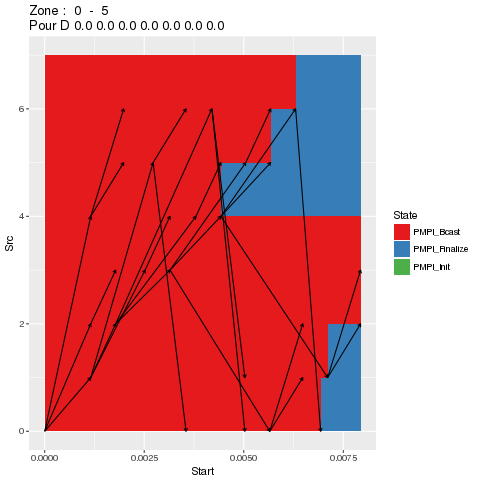

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  5 5 5 6 0 2 2 6 6 0 ...
 $ Dst     : num  6 0 2 0 1 3 4 1 3 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 25 21 23 27 2 11 13 29 30 1 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001157 0.001157    PMPI_Bcast
3     6 0.001157 0.001157 0.000000    PMPI_Bcast
4     6 0.001157 0.005028 0.003871    PMPI_Bcast
5     6 0.005028 0.006482 0.001454    PMPI_Bcast
6     6 0.006482 0.007108 0.000626    PMPI_Bcast
7     6 0.007108 0.007935 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.000000 0.000000    PMPI_Bcast
10    5 0.000000 0.003551 0.003551    PMPI_Bcast
11    5 0.003551 0.005028 0.001477    PMPI_Bcast
12    5 0.005028 0.005654 0.000626    PMPI_Bcast
13    5 0.005654 0.006932 0.001278    PMPI_Bcast
14    5 0.006932 0.007935 0.001003 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.001984 0.001984    PMPI_Bcast
17    4 0.001984 0.003551 0.001567    PMPI_Bcast
18    4 0.003551 0.004201 0.000650    PMPI_Bcast
19    4 0.004201 0.005677 0.001476    PMPI_Bcast
20    4 0.005677 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   5   6  5_6_-3334_3
2  0.000000 0.001157 0.001157   5   0  5_0_-3334_2
3  0.000000 0.001157 0.001157   5   2  5_2_-3334_1
4  0.001157 0.001783 0.000626   6   0  6_0_-3334_9
5  0.001157 0.001783 0.000626   0   1  0_1_-3334_5
6  0.001157 0.001984 0.000827   2   3  2_3_-3334_8
7  0.001157 0.001984 0.000827   2   4  2_4_-3334_6
8  0.001157 0.002522 0.001365   6   1  6_1_-3334_7
9  0.001157 0.002723 0.001566   6   3  6_3_-3334_4
10 0.001783 0.003148 0.001365   0   1 0_1_-3334_12
11 0.002522 0.003148 0.000626   1   2 1_2_-3334_13
12 0.002723 0.003551 0.000828   3   4 3_4_-3334_15
13 0.002723 0.003551 0.000828   3   5 3_5_-3334_14
14 0.001783 0.003799 0.002016   0   2 0_2_-3334_11
15 0.001783 0.004201 0.002418   0   4 0_4_-3334_10
16 0.003148 0.004425 0.001277   1   2 1_2_-3334_18
17 0.003799 0.004425 0.000626   2   3 2_3_-3334_19
18 0.004201 0.005028 0.000827   4   5 4_5_-3334_21
19 0.004201 0.005028 0.000827  

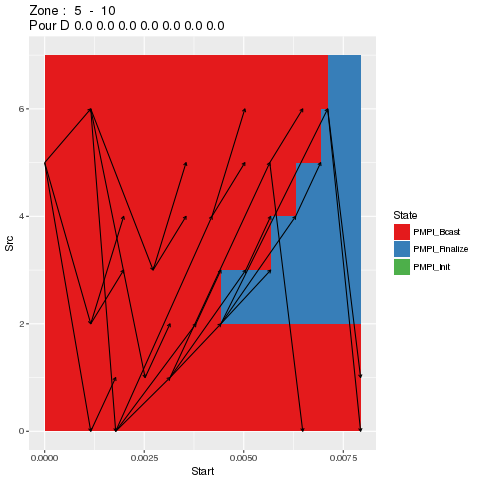

T_curr :  0
D_curr :  0.0 0.0 0.0 0.0 0.0 0.0 0.0
Dprime :  0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027
total execution time :  0

merging : 0.0 0.0 0.0 0.0 0.0 0.0 0.0

  || RESULTS || 

TO EXPLORE : 
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0013 0.0013 0.00253 0.00313 0.0013 ...
 $ End     : num  0.00253 0.00313 0.00375 0.00375 0.00413 ...
 $ Duration: num  0.001226 0.001826 0.001226 0.000626 0.002826 ...
 $ Src     : num  5 5 6 0 5 6 2 2 0 1 ...
 $ Dst     : num  6 0 0 1 2 1 3 4 1 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_10",..: 25 21 27 2 23 29 9 12 1 5 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.001900 0.002526 0.000626    PMPI_Bcast
3     6 0.002526 0.002526 0.000000    PMPI_Bcast
4     6 0.002526 0.007895 0.005369    PMPI_Bcast
5     6 0.007895 0.009363 0.001468    PMPI_Bcast
6     6 0.009363 0.009989 0.000626    PMPI_Bcast
7     6 0.009989 0.010816 0.000827 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.001300 0.001300 0.000000    PMPI_Bcast
10    5 0.001300 0.006429 0.005129    PMPI_Bcast
11    5 0.006429 0.007895 0.001466    PMPI_Bcast
12    5 0.007895 0.008521 0.000626    PMPI_Bcast
13    5 0.008521 0.009422 0.000901    PMPI_Bcast
14    5 0.009422 0.010816 0.001394 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.004963 0.004963    PMPI_Bcast
17    4 0.004963 0.006429 0.001466    PMPI_Bcast
18    4 0.006429 0.007055 0.000626    PMPI_Bcast
19    4 0.007055 0.007980 0.000925    PMPI_Bcast
20    4 0.007980 0.0

      Start      End Duration Src Dst           NA
1  0.001300 0.002526 0.001226   5   6  5_6_-3334_3
2  0.001300 0.003126 0.001826   5   0  5_0_-3334_2
3  0.002526 0.003752 0.001226   6   0  6_0_-3334_6
4  0.003126 0.003752 0.000626   0   1  0_1_-3334_7
5  0.001300 0.004126 0.002826   5   2  5_2_-3334_1
6  0.002526 0.004378 0.001852   6   1  6_1_-3334_5
7  0.004126 0.004963 0.000837   2   3 2_3_-3334_12
8  0.004126 0.004963 0.000837   2   4 2_4_-3334_11
9  0.003752 0.005004 0.001252   0   1 0_1_-3334_10
10 0.004378 0.005139 0.000761   1   2 1_2_-3334_13
11 0.002526 0.005589 0.003063   6   3  6_3_-3334_4
12 0.003752 0.005765 0.002013   0   2  0_2_-3334_9
13 0.005004 0.006391 0.001387   1   2 1_2_-3334_16
14 0.005589 0.006429 0.000840   3   4 3_4_-3334_18
15 0.005589 0.006429 0.000840   3   5 3_5_-3334_17
16 0.005765 0.006550 0.000785   2   3 2_3_-3334_19
17 0.003752 0.007055 0.003303   0   4  0_4_-3334_8
18 0.005004 0.007176 0.002172   1   3 1_3_-3334_15
19 0.006391 0.007802 0.001411  

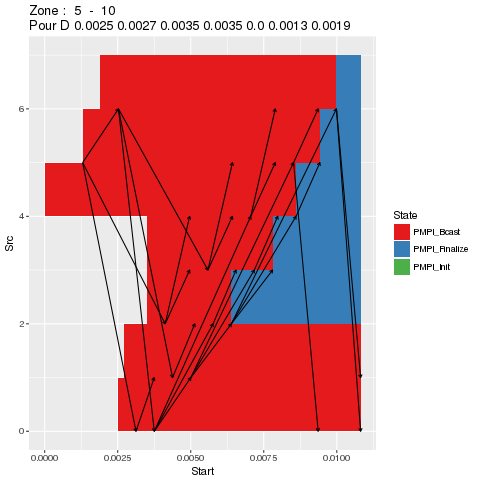

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0013 0.0013 0.00253 0.00313 0.0013 ...
 $ End     : num  0.00253 0.00313 0.00375 0.00375 0.00413 ...
 $ Duration: num  0.001226 0.001826 0.001226 0.000626 0.002826 ...
 $ Src     : num  3 3 4 5 3 4 0 0 5 6 ...
 $ Dst     : num  4 5 5 6 0 6 1 2 6 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_12",..: 15 16 20 26 13 22 1 4 25 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.002700 0.003752 0.001052    PMPI_Bcast
3     6 0.003752 0.004378 0.000626    PMPI_Bcast
4     6 0.004378 0.005004 0.000626    PMPI_Bcast
5     6 0.005004 0.005004 0.000000    PMPI_Bcast
6     6 0.005004 0.010816 0.005812    PMPI_Bcast
7     6 0.010816 0.010816 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.002500 0.003126 0.000626    PMPI_Bcast
10    5 0.003126 0.003752 0.000626    PMPI_Bcast
11    5 0.003752 0.003752 0.000000    PMPI_Bcast
12    5 0.003752 0.009363 0.005611    PMPI_Bcast
13    5 0.009363 0.010816 0.001453    PMPI_Bcast
14    5 0.010816 0.010816 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.001900 0.002526 0.000626    PMPI_Bcast
17    4 0.002526 0.002526 0.000000    PMPI_Bcast
18    4 0.002526 0.007895 0.005369    PMPI_Bcast
19    4 0.007895 0.009363 0.001468    PMPI_Bcast
20    4 0.009363 0.0

      Start      End Duration Src Dst           NA
1  0.001300 0.002526 0.001226   3   4  3_4_-3334_3
2  0.001300 0.003126 0.001826   3   5  3_5_-3334_2
3  0.002526 0.003752 0.001226   4   5  4_5_-3334_6
4  0.003126 0.003752 0.000626   5   6  5_6_-3334_7
5  0.001300 0.004126 0.002826   3   0  3_0_-3334_1
6  0.002526 0.004378 0.001852   4   6  4_6_-3334_5
7  0.004126 0.004963 0.000837   0   1 0_1_-3334_12
8  0.004126 0.004963 0.000837   0   2 0_2_-3334_11
9  0.003752 0.005004 0.001252   5   6 5_6_-3334_10
10 0.004378 0.005139 0.000761   6   0 6_0_-3334_13
11 0.002526 0.005589 0.003063   4   1  4_1_-3334_4
12 0.003752 0.005765 0.002013   5   0  5_0_-3334_9
13 0.005004 0.006391 0.001387   6   0 6_0_-3334_16
14 0.005589 0.006429 0.000840   1   2 1_2_-3334_18
15 0.005589 0.006429 0.000840   1   3 1_3_-3334_17
16 0.005765 0.006550 0.000785   0   1 0_1_-3334_19
17 0.003752 0.007055 0.003303   5   2  5_2_-3334_8
18 0.005004 0.007176 0.002172   6   1 6_1_-3334_15
19 0.006391 0.007802 0.001411  

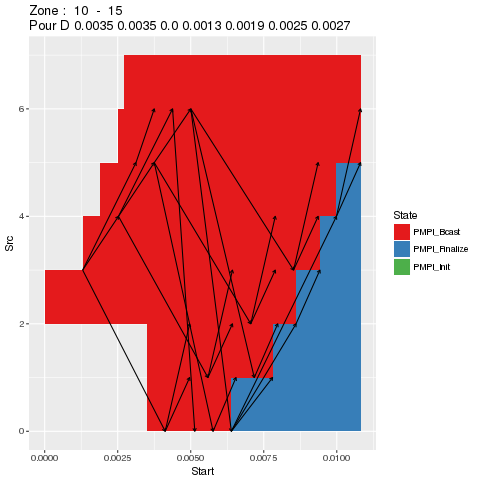

T_curr :  5
D_curr :  0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
Dprime :  0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
total execution time :  0.0044

merging : 0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019

  || RESULTS || 

TO EXPLORE : 
10 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.003

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0014 0.0014 0.00283 0.00363 0.00283 ...
 $ End     : num  0.00283 0.00363 0.00425 0.00425 0.00488 ...
 $ Duration: num  0.001426 0.002226 0.001426 0.000626 0.002052 ...
 $ Src     : num  3 3 4 5 4 3 5 6 0 0 ...
 $ Dst     : num  4 5 5 6 6 0 6 0 1 2 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 15 16 20 26 22 13 25 27 1 4 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.003600 0.004252 0.000652    PMPI_Bcast
3     6 0.004252 0.004878 0.000626    PMPI_Bcast
4     6 0.004878 0.005504 0.000626    PMPI_Bcast
5     6 0.005504 0.005504 0.000000    PMPI_Bcast
6     6 0.005504 0.011732 0.006228    PMPI_Bcast
7     6 0.011732 0.011732 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.003000 0.003626 0.000626    PMPI_Bcast
10    5 0.003626 0.004252 0.000626    PMPI_Bcast
11    5 0.004252 0.004252 0.000000    PMPI_Bcast
12    5 0.004252 0.010279 0.006027    PMPI_Bcast
13    5 0.010279 0.011732 0.001453    PMPI_Bcast
14    5 0.011732 0.011732 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.002200 0.002826 0.000626    PMPI_Bcast
17    4 0.002826 0.002826 0.000000    PMPI_Bcast
18    4 0.002826 0.008809 0.005983    PMPI_Bcast
19    4 0.008809 0.010279 0.001470    PMPI_Bcast
20    4 0.010279 0.0

      Start      End Duration Src Dst           NA
1  0.001400 0.002826 0.001426   3   4  3_4_-3334_3
2  0.001400 0.003626 0.002226   3   5  3_5_-3334_2
3  0.002826 0.004252 0.001426   4   5  4_5_-3334_6
4  0.003626 0.004252 0.000626   5   6  5_6_-3334_7
5  0.002826 0.004878 0.002052   4   6  4_6_-3334_5
6  0.001400 0.005026 0.003626   3   0  3_0_-3334_1
7  0.004252 0.005504 0.001252   5   6 5_6_-3334_10
8  0.004878 0.005870 0.000992   6   0 6_0_-3334_11
9  0.005026 0.005870 0.000844   0   1 0_1_-3334_13
10 0.005026 0.005870 0.000844   0   2 0_2_-3334_12
11 0.004252 0.006496 0.002244   5   0  5_0_-3334_9
12 0.002826 0.006496 0.003670   4   1  4_1_-3334_4
13 0.005504 0.007122 0.001618   6   0 6_0_-3334_16
14 0.006496 0.007339 0.000843   0   1 0_1_-3334_17
15 0.006496 0.007339 0.000843   1   2 1_2_-3334_19
16 0.006496 0.007339 0.000843   1   3 1_3_-3334_18
17 0.005504 0.007965 0.002461   6   1 6_1_-3334_15
18 0.004252 0.007965 0.003713   5   2  5_2_-3334_8
19 0.007122 0.008591 0.001469  

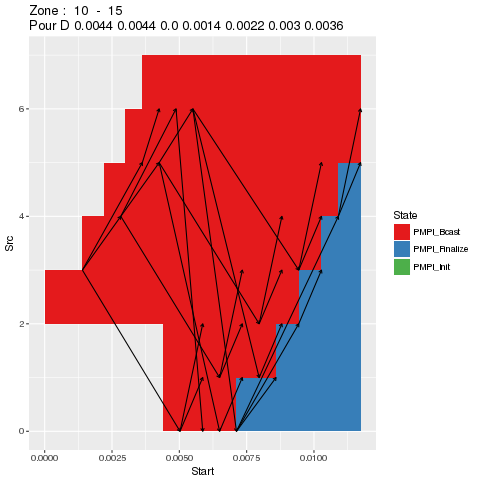

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0014 0.0014 0.00283 0.00363 0.00283 ...
 $ End     : num  0.00283 0.00363 0.00425 0.00425 0.00488 ...
 $ Duration: num  0.001426 0.002226 0.001426 0.000626 0.002052 ...
 $ Src     : num  1 1 2 3 2 1 3 4 5 5 ...
 $ Dst     : num  2 3 3 4 4 5 4 5 6 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_25",..: 5 6 10 16 12 8 15 19 25 22 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.004400 0.005870 0.001470    PMPI_Bcast
3     6 0.005870 0.006496 0.000626    PMPI_Bcast
4     6 0.006496 0.007339 0.000843    PMPI_Bcast
5     6 0.007339 0.007965 0.000626    PMPI_Bcast
6     6 0.007965 0.008591 0.000626    PMPI_Bcast
7     6 0.008591 0.011732 0.003141 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.004400 0.005026 0.000626    PMPI_Bcast
10    5 0.005026 0.005870 0.000844    PMPI_Bcast
11    5 0.005870 0.006496 0.000626    PMPI_Bcast
12    5 0.006496 0.007122 0.000626    PMPI_Bcast
13    5 0.007122 0.007122 0.000000    PMPI_Bcast
14    5 0.007122 0.011732 0.004610 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.003600 0.004252 0.000652    PMPI_Bcast
17    4 0.004252 0.004878 0.000626    PMPI_Bcast
18    4 0.004878 0.005504 0.000626    PMPI_Bcast
19    4 0.005504 0.005504 0.000000    PMPI_Bcast
20    4 0.005504 0.0

      Start      End Duration Src Dst           NA
1  0.001400 0.002826 0.001426   1   2  1_2_-3334_3
2  0.001400 0.003626 0.002226   1   3  1_3_-3334_2
3  0.002826 0.004252 0.001426   2   3  2_3_-3334_6
4  0.003626 0.004252 0.000626   3   4  3_4_-3334_7
5  0.002826 0.004878 0.002052   2   4  2_4_-3334_5
6  0.001400 0.005026 0.003626   1   5  1_5_-3334_1
7  0.004252 0.005504 0.001252   3   4 3_4_-3334_10
8  0.004878 0.005870 0.000992   4   5 4_5_-3334_11
9  0.005026 0.005870 0.000844   5   6 5_6_-3334_13
10 0.005026 0.005870 0.000844   5   0 5_0_-3334_12
11 0.004252 0.006496 0.002244   3   5  3_5_-3334_9
12 0.002826 0.006496 0.003670   2   6  2_6_-3334_4
13 0.005504 0.007122 0.001618   4   5 4_5_-3334_16
14 0.006496 0.007339 0.000843   5   6 5_6_-3334_17
15 0.006496 0.007339 0.000843   6   0 6_0_-3334_19
16 0.006496 0.007339 0.000843   6   1 6_1_-3334_18
17 0.005504 0.007965 0.002461   4   6 4_6_-3334_15
18 0.004252 0.007965 0.003713   3   0  3_0_-3334_8
19 0.007122 0.008591 0.001469  

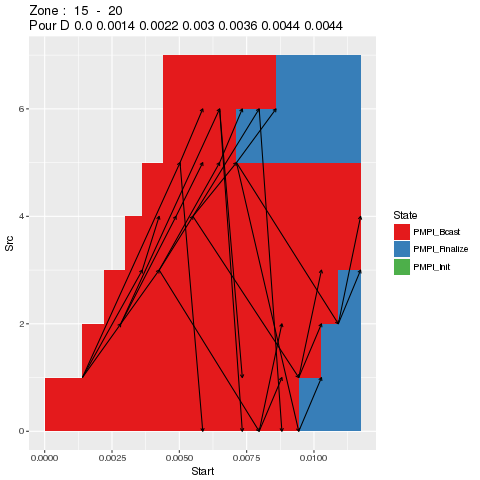

T_curr :  10
D_curr :  0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
Dprime :  0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015
total execution time :  0.0108

merging : 0.0044 0.0044 0.0 0.0014 0.0022 0.003 0.0036
merging : 0.0 0.0014 0.0022 0.003 0.0036 0.0044 0.0044
****** SUCCESS : 2

  || RESULTS || 

TO EXPLORE : 
15 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
20 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
25 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0015 0.0015 0.00293 0.00383 0.00293 ...
 $ End     : num  0.00293 0.00383 0.00445 0.00445 0.00508 ...
 $ Duration: num  0.001426 0.002326 0.001526 0.000626 0.002152 ...
 $ Src     : num  6 6 0 1 0 6 1 2 3 3 ...
 $ Dst     : num  0 1 1 2 2 3 2 3 4 5 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_30",..: 27 28 2 7 4 30 6 10 15 18 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.001500 0.001500 0.000000    PMPI_Bcast
3     6 0.001500 0.007539 0.006039    PMPI_Bcast
4     6 0.007539 0.009009 0.001470    PMPI_Bcast
5     6 0.009009 0.009635 0.000626    PMPI_Bcast
6     6 0.009635 0.010479 0.000844    PMPI_Bcast
7     6 0.010479 0.011932 0.001453 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.006070 0.006070    PMPI_Bcast
10    5 0.006070 0.007539 0.001469    PMPI_Bcast
11    5 0.007539 0.008165 0.000626    PMPI_Bcast
12    5 0.008165 0.009009 0.000844    PMPI_Bcast
13    5 0.009009 0.009635 0.000626    PMPI_Bcast
14    5 0.009635 0.011932 0.002297 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.004600 0.006070 0.001470    PMPI_Bcast
17    4 0.006070 0.006696 0.000626    PMPI_Bcast
18    4 0.006696 0.007539 0.000843    PMPI_Bcast
19    4 0.007539 0.008165 0.000626    PMPI_Bcast
20    4 0.008165 0.0

      Start      End Duration Src Dst           NA
1  0.001500 0.002926 0.001426   6   0  6_0_-3334_3
2  0.001500 0.003826 0.002326   6   1  6_1_-3334_2
3  0.002926 0.004452 0.001526   0   1  0_1_-3334_6
4  0.003826 0.004452 0.000626   1   2  1_2_-3334_7
5  0.002926 0.005078 0.002152   0   2  0_2_-3334_5
6  0.001500 0.005226 0.003726   6   3  6_3_-3334_1
7  0.004452 0.005704 0.001252   1   2 1_2_-3334_10
8  0.005078 0.006070 0.000992   2   3 2_3_-3334_11
9  0.005226 0.006070 0.000844   3   4 3_4_-3334_13
10 0.005226 0.006070 0.000844   3   5 3_5_-3334_12
11 0.004452 0.006696 0.002244   1   3  1_3_-3334_9
12 0.002926 0.006696 0.003770   0   4  0_4_-3334_4
13 0.005704 0.007322 0.001618   2   3 2_3_-3334_16
14 0.006696 0.007539 0.000843   3   4 3_4_-3334_17
15 0.006696 0.007539 0.000843   4   5 4_5_-3334_19
16 0.006696 0.007539 0.000843   4   6 4_6_-3334_18
17 0.005704 0.008165 0.002461   2   4 2_4_-3334_15
18 0.004452 0.008165 0.003713   1   5  1_5_-3334_8
19 0.007322 0.008791 0.001469  

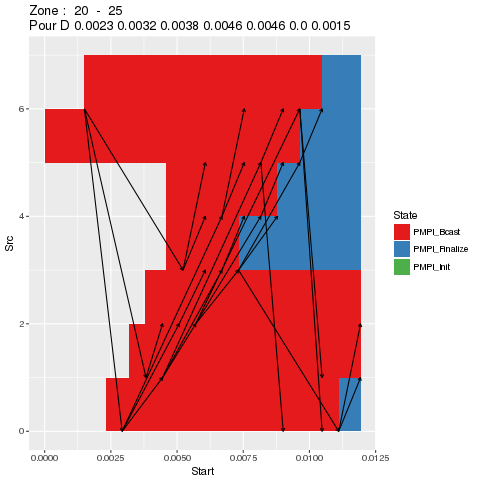

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0 0 0 0.00116 0.00116 ...
 $ End     : num  0.00116 0.00116 0.00116 0.00178 0.00178 ...
 $ Duration: num  0.001157 0.001157 0.001157 0.000626 0.000626 ...
 $ Src     : num  4 4 4 5 6 1 1 5 5 6 ...
 $ Dst     : num  5 6 1 6 0 2 3 0 2 0 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_13",..: 19 20 17 26 28 7 9 23 24 27 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.001157 0.001157    PMPI_Bcast
3     6 0.001157 0.001783 0.000626    PMPI_Bcast
4     6 0.001783 0.001783 0.000000    PMPI_Bcast
5     6 0.001783 0.006482 0.004699    PMPI_Bcast
6     6 0.006482 0.007935 0.001453    PMPI_Bcast
7     6 0.007935 0.007935 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.000000 0.001157 0.001157    PMPI_Bcast
10    5 0.001157 0.001157 0.000000    PMPI_Bcast
11    5 0.001157 0.005028 0.003871    PMPI_Bcast
12    5 0.005028 0.006482 0.001454    PMPI_Bcast
13    5 0.006482 0.007108 0.000626    PMPI_Bcast
14    5 0.007108 0.007935 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.000000 0.000000 0.000000    PMPI_Bcast
17    4 0.000000 0.003551 0.003551    PMPI_Bcast
18    4 0.003551 0.005028 0.001477    PMPI_Bcast
19    4 0.005028 0.005654 0.000626    PMPI_Bcast
20    4 0.005654 0.0

      Start      End Duration Src Dst           NA
1  0.000000 0.001157 0.001157   4   5  4_5_-3334_3
2  0.000000 0.001157 0.001157   4   6  4_6_-3334_2
3  0.000000 0.001157 0.001157   4   1  4_1_-3334_1
4  0.001157 0.001783 0.000626   5   6  5_6_-3334_9
5  0.001157 0.001783 0.000626   6   0  6_0_-3334_5
6  0.001157 0.001984 0.000827   1   2  1_2_-3334_8
7  0.001157 0.001984 0.000827   1   3  1_3_-3334_6
8  0.001157 0.002522 0.001365   5   0  5_0_-3334_7
9  0.001157 0.002723 0.001566   5   2  5_2_-3334_4
10 0.001783 0.003148 0.001365   6   0 6_0_-3334_12
11 0.002522 0.003148 0.000626   0   1 0_1_-3334_13
12 0.002723 0.003551 0.000828   2   3 2_3_-3334_15
13 0.002723 0.003551 0.000828   2   4 2_4_-3334_14
14 0.001783 0.003799 0.002016   6   1 6_1_-3334_11
15 0.001783 0.004201 0.002418   6   3 6_3_-3334_10
16 0.003148 0.004425 0.001277   0   1 0_1_-3334_18
17 0.003799 0.004425 0.000626   1   2 1_2_-3334_19
18 0.004201 0.005028 0.000827   3   4 3_4_-3334_21
19 0.004201 0.005028 0.000827  

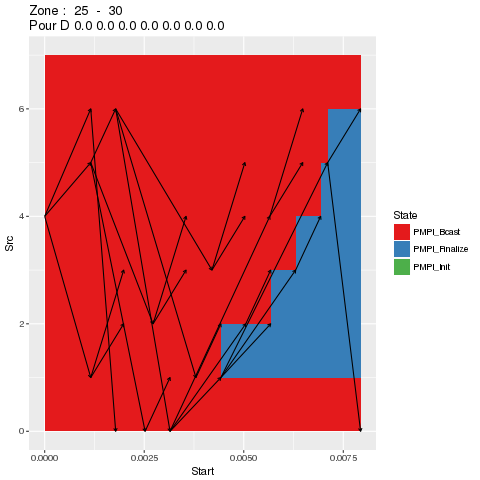

T_curr :  20
D_curr :  0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015
Dprime :  0.0035 0.0 0.0013 0.0019 0.0025 0.0027 0.0035
total execution time :  0.025

merging : 0.0023 0.0032 0.0038 0.0046 0.0046 0.0 0.0015

  || RESULTS || 

TO EXPLORE : 
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0044 0.0044 0.0 0.0014 0.0022 0.

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0015 0.0015 0.00293 0.00383 0.00293 ...
 $ End     : num  0.00293 0.00383 0.00445 0.00445 0.00508 ...
 $ Duration: num  0.001426 0.002326 0.001526 0.000626 0.002152 ...
 $ Src     : num  4 4 5 6 5 4 6 0 1 1 ...
 $ Dst     : num  5 6 6 0 0 1 0 1 2 3 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_11",..: 19 20 26 28 23 17 27 1 5 8 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.003200 0.003826 0.000626    PMPI_Bcast
3     6 0.003826 0.004452 0.000626    PMPI_Bcast
4     6 0.004452 0.004452 0.000000    PMPI_Bcast
5     6 0.004452 0.010479 0.006027    PMPI_Bcast
6     6 0.010479 0.011932 0.001453    PMPI_Bcast
7     6 0.011932 0.011932 0.000000 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.002300 0.002926 0.000626    PMPI_Bcast
10    5 0.002926 0.002926 0.000000    PMPI_Bcast
11    5 0.002926 0.009009 0.006083    PMPI_Bcast
12    5 0.009009 0.010479 0.001470    PMPI_Bcast
13    5 0.010479 0.011105 0.000626    PMPI_Bcast
14    5 0.011105 0.011932 0.000827 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.001500 0.001500 0.000000    PMPI_Bcast
17    4 0.001500 0.007539 0.006039    PMPI_Bcast
18    4 0.007539 0.009009 0.001470    PMPI_Bcast
19    4 0.009009 0.009635 0.000626    PMPI_Bcast
20    4 0.009635 0.0

      Start      End Duration Src Dst           NA
1  0.001500 0.002926 0.001426   4   5  4_5_-3334_3
2  0.001500 0.003826 0.002326   4   6  4_6_-3334_2
3  0.002926 0.004452 0.001526   5   6  5_6_-3334_6
4  0.003826 0.004452 0.000626   6   0  6_0_-3334_7
5  0.002926 0.005078 0.002152   5   0  5_0_-3334_5
6  0.001500 0.005226 0.003726   4   1  4_1_-3334_1
7  0.004452 0.005704 0.001252   6   0 6_0_-3334_10
8  0.005078 0.006070 0.000992   0   1 0_1_-3334_11
9  0.005226 0.006070 0.000844   1   2 1_2_-3334_13
10 0.005226 0.006070 0.000844   1   3 1_3_-3334_12
11 0.004452 0.006696 0.002244   6   1  6_1_-3334_9
12 0.002926 0.006696 0.003770   5   2  5_2_-3334_4
13 0.005704 0.007322 0.001618   0   1 0_1_-3334_16
14 0.006696 0.007539 0.000843   1   2 1_2_-3334_17
15 0.006696 0.007539 0.000843   2   3 2_3_-3334_19
16 0.006696 0.007539 0.000843   2   4 2_4_-3334_18
17 0.005704 0.008165 0.002461   0   2 0_2_-3334_15
18 0.004452 0.008165 0.003713   6   3  6_3_-3334_8
19 0.007322 0.008791 0.001469  

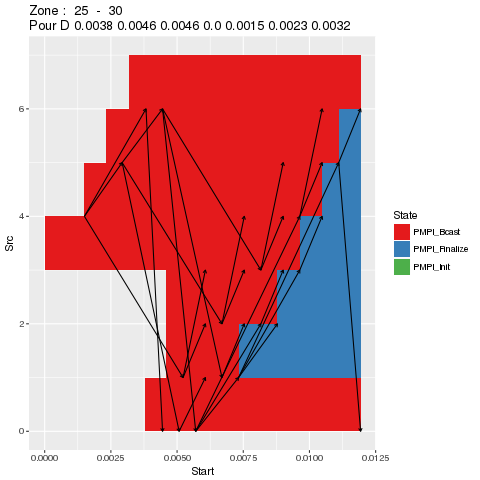

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0013 0.0013 0.00253 0.00313 0.0013 ...
 $ End     : num  0.00253 0.00313 0.00375 0.00375 0.00413 ...
 $ Duration: num  0.001226 0.001826 0.001226 0.000626 0.002826 ...
 $ Src     : num  2 2 3 4 2 3 6 6 4 5 ...
 $ Dst     : num  3 4 4 5 6 5 0 1 5 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_18",..: 8 9 14 19 11 16 25 28 18 23 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.003500 0.004126 0.000626    PMPI_Bcast
3     6 0.004126 0.005139 0.001013    PMPI_Bcast
4     6 0.005139 0.005765 0.000626    PMPI_Bcast
5     6 0.005765 0.006391 0.000626    PMPI_Bcast
6     6 0.006391 0.006391 0.000000    PMPI_Bcast
7     6 0.006391 0.010816 0.004425 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.002700 0.003752 0.001052    PMPI_Bcast
10    5 0.003752 0.004378 0.000626    PMPI_Bcast
11    5 0.004378 0.005004 0.000626    PMPI_Bcast
12    5 0.005004 0.005004 0.000000    PMPI_Bcast
13    5 0.005004 0.010816 0.005812    PMPI_Bcast
14    5 0.010816 0.010816 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.002500 0.003126 0.000626    PMPI_Bcast
17    4 0.003126 0.003752 0.000626    PMPI_Bcast
18    4 0.003752 0.003752 0.000000    PMPI_Bcast
19    4 0.003752 0.009363 0.005611    PMPI_Bcast
20    4 0.009363 0.0

      Start      End Duration Src Dst           NA
1  0.001300 0.002526 0.001226   2   3  2_3_-3334_3
2  0.001300 0.003126 0.001826   2   4  2_4_-3334_2
3  0.002526 0.003752 0.001226   3   4  3_4_-3334_6
4  0.003126 0.003752 0.000626   4   5  4_5_-3334_7
5  0.001300 0.004126 0.002826   2   6  2_6_-3334_1
6  0.002526 0.004378 0.001852   3   5  3_5_-3334_5
7  0.004126 0.004963 0.000837   6   0 6_0_-3334_12
8  0.004126 0.004963 0.000837   6   1 6_1_-3334_11
9  0.003752 0.005004 0.001252   4   5 4_5_-3334_10
10 0.004378 0.005139 0.000761   5   6 5_6_-3334_13
11 0.002526 0.005589 0.003063   3   0  3_0_-3334_4
12 0.003752 0.005765 0.002013   4   6  4_6_-3334_9
13 0.005004 0.006391 0.001387   5   6 5_6_-3334_16
14 0.005589 0.006429 0.000840   0   1 0_1_-3334_18
15 0.005589 0.006429 0.000840   0   2 0_2_-3334_17
16 0.005765 0.006550 0.000785   6   0 6_0_-3334_19
17 0.003752 0.007055 0.003303   4   1  4_1_-3334_8
18 0.005004 0.007176 0.002172   5   0 5_0_-3334_15
19 0.006391 0.007802 0.001411  

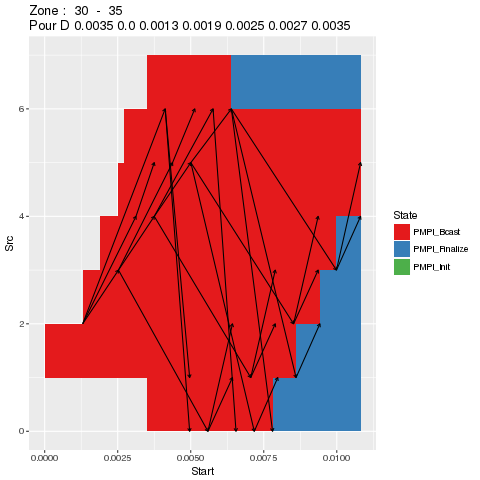

T_curr :  25
D_curr :  0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032
Dprime :  0.0014 0.0022 0.003 0.0036 0.0044 0.0044 0.0
total execution time :  0.0323

merging : 0.0038 0.0046 0.0046 0.0 0.0015 0.0023 0.0032

  || RESULTS || 

TO EXPLORE : 
30 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
35 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
40 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
45 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
50 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
55 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
60 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
65 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
70 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
75 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
80 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
85 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
90 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
95 -> 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019', 1, 0, 0.0044)
5
	0.0 0.0 0.0 0.0 0.0 0.0 0.0
		('0.0035 0.0035 0.0 0.0013 0.0019 0.0025 0.0027', 1, 1, 0.0044)
	0.0025 0.0027 0.0035 0.0035 0.0 0.0013 0.0019
		('0.0044 0.0044 0.0 0.0014 0.0022 0.

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0015 0.0015 0.00293 0.00383 0.00293 ...
 $ End     : num  0.00293 0.00383 0.00445 0.00445 0.00508 ...
 $ Duration: num  0.001426 0.002326 0.001526 0.000626 0.002152 ...
 $ Src     : num  2 2 3 4 3 2 4 5 6 6 ...
 $ Dst     : num  3 4 4 5 5 6 5 6 0 1 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_19",..: 8 9 14 19 16 11 18 23 25 28 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.004600 0.005226 0.000626    PMPI_Bcast
3     6 0.005226 0.006070 0.000844    PMPI_Bcast
4     6 0.006070 0.006696 0.000626    PMPI_Bcast
5     6 0.006696 0.007322 0.000626    PMPI_Bcast
6     6 0.007322 0.007322 0.000000    PMPI_Bcast
7     6 0.007322 0.011932 0.004610 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.003800 0.004452 0.000652    PMPI_Bcast
10    5 0.004452 0.005078 0.000626    PMPI_Bcast
11    5 0.005078 0.005704 0.000626    PMPI_Bcast
12    5 0.005704 0.005704 0.000000    PMPI_Bcast
13    5 0.005704 0.011932 0.006228    PMPI_Bcast
14    5 0.011932 0.011932 0.000000 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.003200 0.003826 0.000626    PMPI_Bcast
17    4 0.003826 0.004452 0.000626    PMPI_Bcast
18    4 0.004452 0.004452 0.000000    PMPI_Bcast
19    4 0.004452 0.010479 0.006027    PMPI_Bcast
20    4 0.010479 0.0

      Start      End Duration Src Dst           NA
1  0.001500 0.002926 0.001426   2   3  2_3_-3334_3
2  0.001500 0.003826 0.002326   2   4  2_4_-3334_2
3  0.002926 0.004452 0.001526   3   4  3_4_-3334_6
4  0.003826 0.004452 0.000626   4   5  4_5_-3334_7
5  0.002926 0.005078 0.002152   3   5  3_5_-3334_5
6  0.001500 0.005226 0.003726   2   6  2_6_-3334_1
7  0.004452 0.005704 0.001252   4   5 4_5_-3334_10
8  0.005078 0.006070 0.000992   5   6 5_6_-3334_11
9  0.005226 0.006070 0.000844   6   0 6_0_-3334_13
10 0.005226 0.006070 0.000844   6   1 6_1_-3334_12
11 0.004452 0.006696 0.002244   4   6  4_6_-3334_9
12 0.002926 0.006696 0.003770   3   0  3_0_-3334_4
13 0.005704 0.007322 0.001618   5   6 5_6_-3334_16
14 0.006696 0.007539 0.000843   6   0 6_0_-3334_17
15 0.006696 0.007539 0.000843   0   1 0_1_-3334_19
16 0.006696 0.007539 0.000843   0   2 0_2_-3334_18
17 0.005704 0.008165 0.002461   5   0 5_0_-3334_15
18 0.004452 0.008165 0.003713   4   1  4_1_-3334_8
19 0.007322 0.008791 0.001469  

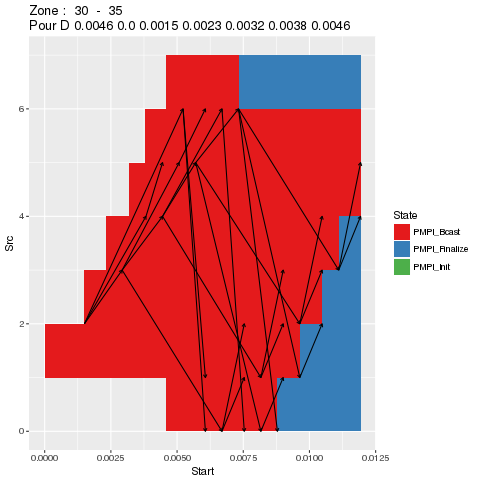

'data.frame':	30 obs. of  6 variables:
 $ Start   : num  0.0014 0.0014 0.00283 0.00363 0.00283 ...
 $ End     : num  0.00283 0.00363 0.00425 0.00425 0.00488 ...
 $ Duration: num  0.001426 0.002226 0.001426 0.000626 0.002052 ...
 $ Src     : num  0 0 1 2 1 0 2 3 4 4 ...
 $ Dst     : num  1 2 2 3 3 4 3 4 5 6 ...
 $ NA      : Factor w/ 30 levels "0_1_-3334_28",..: 2 3 7 12 9 5 11 16 20 23 ...


   Rank    Start      End Duration         State
1     6 0.000000 0.000000 0.000000     PMPI_Init
2     6 0.000000 0.005870 0.005870    PMPI_Bcast
3     6 0.005870 0.007339 0.001469    PMPI_Bcast
4     6 0.007339 0.007965 0.000626    PMPI_Bcast
5     6 0.007965 0.008809 0.000844    PMPI_Bcast
6     6 0.008809 0.009435 0.000626    PMPI_Bcast
7     6 0.009435 0.011732 0.002297 PMPI_Finalize
8     5 0.000000 0.000000 0.000000     PMPI_Init
9     5 0.004400 0.005870 0.001470    PMPI_Bcast
10    5 0.005870 0.006496 0.000626    PMPI_Bcast
11    5 0.006496 0.007339 0.000843    PMPI_Bcast
12    5 0.007339 0.007965 0.000626    PMPI_Bcast
13    5 0.007965 0.008591 0.000626    PMPI_Bcast
14    5 0.008591 0.011732 0.003141 PMPI_Finalize
15    4 0.000000 0.000000 0.000000     PMPI_Init
16    4 0.004400 0.005026 0.000626    PMPI_Bcast
17    4 0.005026 0.005870 0.000844    PMPI_Bcast
18    4 0.005870 0.006496 0.000626    PMPI_Bcast
19    4 0.006496 0.007122 0.000626    PMPI_Bcast
20    4 0.007122 0.0

      Start      End Duration Src Dst           NA
1  0.001400 0.002826 0.001426   0   1  0_1_-3334_3
2  0.001400 0.003626 0.002226   0   2  0_2_-3334_2
3  0.002826 0.004252 0.001426   1   2  1_2_-3334_6
4  0.003626 0.004252 0.000626   2   3  2_3_-3334_7
5  0.002826 0.004878 0.002052   1   3  1_3_-3334_5
6  0.001400 0.005026 0.003626   0   4  0_4_-3334_1
7  0.004252 0.005504 0.001252   2   3 2_3_-3334_10
8  0.004878 0.005870 0.000992   3   4 3_4_-3334_11
9  0.005026 0.005870 0.000844   4   5 4_5_-3334_13
10 0.005026 0.005870 0.000844   4   6 4_6_-3334_12
11 0.004252 0.006496 0.002244   2   4  2_4_-3334_9
12 0.002826 0.006496 0.003670   1   5  1_5_-3334_4
13 0.005504 0.007122 0.001618   3   4 3_4_-3334_16
14 0.006496 0.007339 0.000843   4   5 4_5_-3334_17
15 0.006496 0.007339 0.000843   5   6 5_6_-3334_19
16 0.006496 0.007339 0.000843   5   0 5_0_-3334_18
17 0.005504 0.007965 0.002461   3   5 3_5_-3334_15
18 0.004252 0.007965 0.003713   2   6  2_6_-3334_8
19 0.007122 0.008591 0.001469  

In [ ]:
DEBUG = True
# Nbr pcs
NPROCS = 7
    
# Nbr itérations
N = 100

# taille paquet d'itérations
fragment_size = 5

# Precision désirée pour le recollement des trajectoires
precision = 4

gap = 0.0005

# mode de génération de l'état initial à chaque round
mode_opt = ["FIX", "RAND", "RAND_INF", "RAND_SUP","SMART_GUESS","SMART_BORDERS"]
mode = mode_opt[0]

catch_me = False

# Lancement de la simulation
simulation(N, NPROCS, fragment_size, precision, mode, gap, catch_me)

#### Publication des résultats sur GitHub : https://github.com/HooBaeBoo/Stage-POLARIS

In [ ]:
%%bash -s $experiment_name $site
git add .
git commit -m 'Automatic results update : '"$1"' --- '"$2 "' GGplot fixing'

#### Fin d'expérience : suppression du job

In [ ]:
oardel([(jobid,site)])

### Zone Test (à ignorer)

In [ ]:
def help(q):
    %R -i q
    %R print(q)
help(2)

In [ ]:
a = [1, 2 ,3]
b = [2, 3, 4]
math.isclose(a, b, abs_tol = 2)

In [ ]:
tue = 6

In [ ]:
def play(tue):
    tue = tue -1
    return tue


a = play(tue)

while (a > 2):
    print(a)
    a = play(a)